# Data Preprocess

The dataset used in this experiment is National Travel Survey (NTS) data from 2005 to 2016, which can be assessed at the [UK Data Service](https://beta.ukdataservice.ac.uk/datacatalogue/studies/study?id=5340). It provides three kinds of file formats: SPSS,STATA, and TAB. Here we use STATA format.

The population density data are publicly provided by [London Data Store](https://data.london.gov.uk/dataset/land-area-and-population-density-ward-and-borough).

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import os
import scipy
from scipy.signal import savgol_filter

import analysis
import data_preprocess
import nn
import plot

d:\gis\anaconda3\envs\zillow\lib\site-packages\tensorflow\python\framework\dtypes.py:469: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
d:\gis\anaconda3\envs\zillow\lib\site-packages\tensorflow\python\framework\dtypes.py:470: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
d:\gis\anaconda3\envs\zillow\lib\site-packages\tensorflow\python\framework\dtypes.py:471: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
d:\gis\anaconda3\envs\zillow\lib\site-packages\tensorflow\python\framework\dtypes.py:472: Futu

In [23]:
path = os.getcwd()      
if not os.path.exists(path+'\\image'):os.makedirs(path+'\\image')
if not os.path.exists(path+'\\parameter'):os.makedirs(path+'\\parameter')
if not os.path.exists(path+'\\summary statistics'):os.makedirs(path+'\\summary statistics')
if not os.path.exists(path+'\\results'):os.makedirs(path+'\\results')
    
# we generate three folders in 'results' folder to store the training results of three ML models
if not os.path.exists(path+'\\results\\rebnn'):os.makedirs(path+'\\results\\rebnn')
if not os.path.exists(path+'\\results\\bnn'):os.makedirs(path+'\\results\\bnn')
if not os.path.exists(path+'\\results\\dnn'):os.makedirs(path+'\\results\\dnn')
if not os.path.exists(path+'\\results\\mnl'):os.makedirs(path+'\\results\\mnl')

# then we generate 50 folders for each model to enable store 50 times training results
for i in range(50):
    if not os.path.exists(path+f'\\results\\rebnn\\train{i+1}'):os.makedirs(path+f'\\results\\rebnn\\train{i+1}')
    if not os.path.exists(path+f'\\results\\bnn\\train{i+1}'):os.makedirs(path+f'\\results\\bnn\\train{i+1}')
    if not os.path.exists(path+f'\\results\\dnn\\train{i+1}'):os.makedirs(path+f'\\results\\dnn\\train{i+1}')

In [ ]:
# Read the origin dataset 
data_trip = pd.read_stata('data/trip_eul_2002-2019.dta',convert_categoricals=False)
data_indi = pd.read_stata('data/individual_eul_2002-2019.dta',convert_categoricals=False)
data_hous = pd.read_stata('data/household_eul_2002-2019.dta',convert_categoricals=False)
data_psu=pd.read_stata('data/psu_eul_2002-2019.dta',convert_categoricals=False)

# preprocess the data and save them in the local
data_preprocess.data_clean(data_trip,data_hous,data_indi,data_psu,standard=True,statistics=True)
data_preprocess.data_clean(data_trip,data_hous,data_indi,data_psu,standard=False,statistics=False)

In [119]:
# Read the preprocessed dataset 
data_stand=pd.read_csv('data_stand.csv')
data_non_stand=pd.read_csv('data_non_stand.csv')

#sort by Mode
data_stand.sort_values(by=['Mode'],inplace = True)
data_non_stand.sort_values(by=['Mode'],inplace = True)

#reindex
data_stand.reset_index(inplace = True)
data_non_stand.reset_index(inplace = True)

#drop unuseful columns
data_stand.drop(columns=['level_0', 'Unnamed: 0','index'],inplace = True)
data_non_stand.drop(columns=['level_0', 'Unnamed: 0','index'],inplace = True)

# Data Exploration

## Numbers of individuals and households

How many individuals and households are interviewed in these surveys?

In [3]:
print(f'Individuals: {len(set(data_non_stand.IndividualID))}')
print(f'Households: {len(set(data_non_stand.HouseholdID))}')

Individuals: 121765
Households: 69208


## Trip frequency by mode choice in 2016

In [187]:
data_non_stand=data_non_stand[data_non_stand.Year==2016].sort_values(by=['Mode','Household_region']).reset_index(drop=True)

In [198]:
freq_mode=pd.DataFrame(columns=['Mode','Frequency','Percentage'],index=range(1,6))
freq_mode['Mode']=travel_mode
freq_mode['Frequency']=data_non_stand.Mode.value_counts()
freq_mode['Percentage']=freq_mode['Frequency']/data_non_stand.Mode.count()
freq_mode.to_csv('results\\exploration_freq_mode.csv')
freq_mode

Mode  Frequency  Percentage
1        Walk      16649    0.099268
2     Bicycle       3165    0.018871
3  Car or van     131621    0.784780
4         Bus       8867    0.052869
5        Rail       7415    0.044211

## Travel mode share by different social group

### Region 

In [308]:
freq_mode_region=pd.DataFrame(columns=region_name,index=range(1,6))
for i in range(len(region_name)):
    freq_mode_region[region_name[i]]=data_non_stand[data_non_stand.Household_region==i+1].Mode.value_counts()
freq_mode_region.index=travel_mode
freq_mode_region=freq_mode_region.reindex(['Car or van','Walk','Bus','Rail','Bicycle'],axis = 'rows')
freq_mode_region

North East  North West  Yorkshire and the Humber  East Midlands  \
Car or van        6099       18421                     13154          12754   
Walk               806        2321                      1614           1541   
Bus                630        1216                       762            629   
Rail                10         476                       241            151   
Bicycle             96         350                       252            258   

            West Midlands  East of England  London  South East  South West  
Car or van          14513            16989   10512       24895       14284  
Walk                 1319             1894    2333        2785        2036  
Bus                   786              587    2812         780         665  
Rail                  237              968    3983        1136         213  
Bicycle               203              555     528         512         411

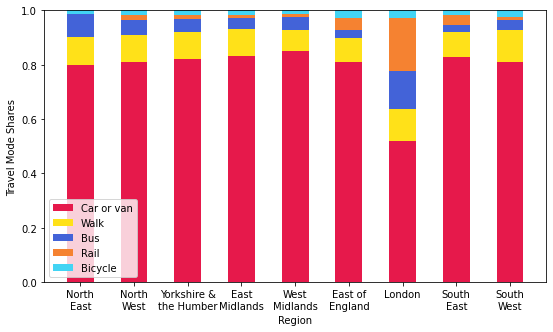

In [309]:
importlib.reload(plot)
results=dict.fromkeys(region_name)
for i in range(len(region_name)):
    results[region_name[i]]= freq_mode_region[region_name[i]] / freq_mode_region[region_name[i]].sum()
    
plot.Mode_Share_Group(results, freq_mode_region,figsize=(9,5),region=True)
plt.xlabel('Region')

plt.savefig('image\\share_region.png',bbox_inches='tight',dpi=300)

### Age group

In [300]:
age=['0-16','17-20','21-29','30-39','40-49','50-59','60+']
age_num=[14,19,25,35,45,55,62]
freq_mode_age=pd.DataFrame(columns=age,index=range(1,6))
for i in range(len(age)):
    freq_mode_age[age[i]]=data_non_stand[data_non_stand.Individual_age==age_num[i]].Mode.value_counts()
freq_mode_age.index=travel_mode
freq_mode_age=freq_mode_age.reindex(['Car or van','Walk','Bus','Rail','Bicycle'],axis = 'rows')
freq_mode_age

0-16  17-20  21-29  30-39  40-49  50-59    60+
Car or van   618   4137  13152  24721  26460  26812  35721
Walk         257   1067   2121   2969   3053   2974   4208
Bus          254   1080   1333   1505   1250   1002   2443
Rail         129    439   1557   2066   1426   1091    707
Bicycle       72     98    415    637    795    553    595

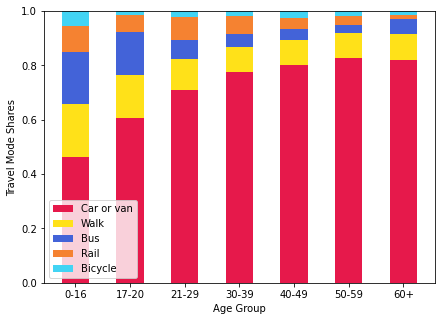

In [301]:
importlib.reload(plot)
results=dict.fromkeys(age)
for i in range(len(age)):
    results[age[i]]=freq_mode_age[age[i]]/freq_mode_age[age[i]].sum()

plot.Mode_Share_Group(results, freq_mode_age,figsize=(7,5))
plt.xlabel('Age Group')

plt.savefig('image\\share_age.png',bbox_inches='tight',dpi=300)

### Gender

In [302]:
gender=['Male','Female']
gender_num=[1,0]
freq_mode_gender=pd.DataFrame(columns=gender,index=range(1,6))
for i in range(len(gender)):
    freq_mode_gender[gender[i]]=data_non_stand[data_non_stand.Individual_gender_1==gender_num[i]].Mode.value_counts()
freq_mode_gender.index=travel_mode
freq_mode_gender=freq_mode_gender.reindex(['Car or van','Walk','Bus','Rail','Bicycle'],axis = 'rows')
freq_mode_gender

Male  Female
Car or van  61536   70085
Walk         7193    9456
Bus          3437    5430
Rail         4026    3389
Bicycle      2313     852

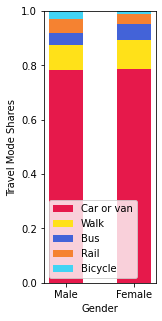

In [303]:
results=dict.fromkeys(gender)
for i in range(len(gender)):
    results[gender[i]]=freq_mode_gender[gender[i]]/freq_mode_gender[gender[i]].sum()

plot.Mode_Share_Group(results, freq_mode_gender,figsize=(2,5))
plt.xlabel('Gender')

plt.savefig('image\\share_gender.png',bbox_inches='tight',dpi=300)

### Travel Purpose

In [306]:
purp=['Commuting','Business','Education','Shopping','Personal\nbusiness','Leisure','Other']
purp_series=[data_non_stand.Trip_purpose_1,data_non_stand.Trip_purpose_2,data_non_stand.Trip_purpose_3,data_non_stand.Trip_purpose_4,
            data_non_stand.Trip_purpose_5,data_non_stand.Trip_purpose_6]
index=data_non_stand.index
freq_mode_purp=pd.DataFrame(columns=purp,index=range(1,6))
for i in range(len(purp)-1):
    freq_mode_purp[purp[i]]=data_non_stand[purp_series[i]==1].Mode.value_counts()
    index.drop(data_non_stand[purp_series[i]==1].index)
freq_mode_purp[purp[6]]=data_non_stand.loc[index].Mode.value_counts()
freq_mode_purp.index=travel_mode
freq_mode_purp=freq_mode_purp.reindex(['Car or van','Walk','Bus','Rail','Bicycle'],axis = 'rows')
freq_mode_purp

Commuting  Business  Education  Shopping  Personal\nbusiness  \
Car or van      24104      7080       8336     26846               13290   
Walk             1934       218       1566      2731                1167   
Bus              2358       217        997      2228                 864   
Rail             3777       827        399       319                 345   
Bicycle          1396        94        145       395                 160   

            Leisure   Other  
Car or van    38463  131621  
Walk           2879   16649  
Bus            2034    8867  
Rail           1669    7415  
Bicycle         952    3165

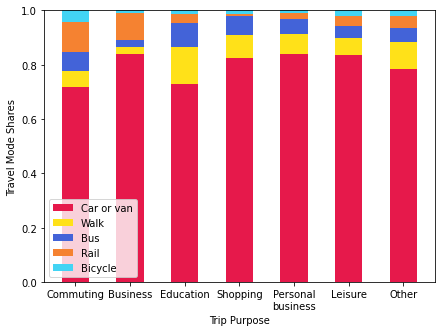

In [307]:
results=dict.fromkeys(purp)
for i in range(len(purp)):
    results[purp[i]]=freq_mode_purp[purp[i]]/freq_mode_purp[purp[i]].sum()

plot.Mode_Share_Group(results, freq_mode_purp,figsize=(7,5))
plt.xlabel('Trip Purpose')

plt.savefig('image\\share_purp.png',bbox_inches='tight',dpi=300)

## Correlation matrix of variables

In [17]:
years_str=plot.get_years()
region_name =plot.get_region()
travel_mode = plot.get_modes()
fixed_effect = nn.get_vars()

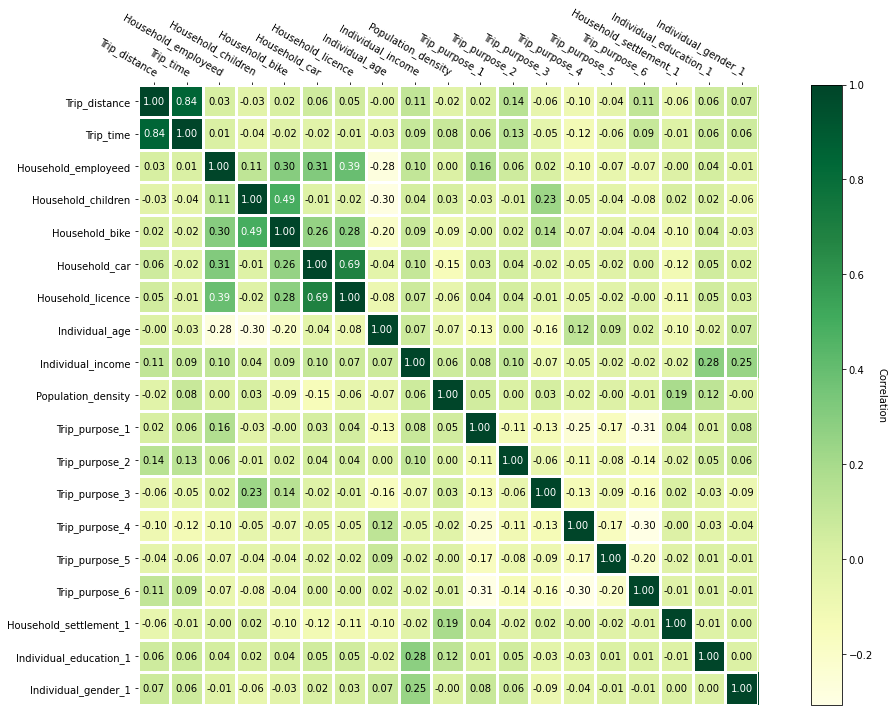

In [41]:
fig, ax = plt.subplots(figsize=(15, 10))

im, cbar = plot.heatmap(df.corr().values, fixed_effect, ax=ax,cmap="YlGn", cbarlabel="Correlation")
texts = plot.annotate_heatmap(im)

fig.tight_layout()
plt.savefig('image\\corr.png',bbox_inches='tight',dpi=300)

# Random Effect-Bayesian Neural Network (RE-BNN)

## Hyperparameter searching for RE-BNN

We use two datasets (standardisation and non-standardisation) and try different numbers of hidden units and different learning rates to find which combination leads to best predictive performance.

In [3]:
# find the best parameter
learning_rate_list=[0.1,0.01, 1e-3, 1e-4]
n_hidden_list=[5,10,15, 25, 50, 100]

data_test1=data_stand.sample(100000,random_state=42)
data_test1.reset_index(inplace=True)
accuracy_test1=np.zeros((len(learning_rate_list), len(n_hidden_list))) 

for i in range(len(learning_rate_list)):
    list1=[]
    for j in range(len(n_hidden_list)):
        Test_accuracy=nn.REBNN_MODEL(data_test1,f'data1{i}{j}',n_hidden=n_hidden_list[j],learning_rate=learning_rate_list[i],test=True)
        list1.append(Test_accuracy)
    accuracy_test1[i]=list1
    
pd.DataFrame(accuracy_test1).to_csv('parameter\\hp_searching_stand.csv')

data_test2=data_non_stand.sample(100000,random_state=42)
data_test2.reset_index(inplace=True)
accuracy_test2=np.zeros((len(learning_rate_list), len(n_hidden_list))) 

for i in range(len(learning_rate_list)):
    list1=[]
    for j in range(len(n_hidden_list)):
        Test_accuracy=nn.REBNN_MODEL(data_test2,f'data2{i}{j}',n_hidden=n_hidden_list[j],learning_rate=learning_rate_list[i],test=True)
        list1.append(Test_accuracy)
    accuracy_test2[i]=list1
    
pd.DataFrame(accuracy_test2).to_csv('parameter\\hp_searching_nonstand.csv')

Start training RE-BNN data100.
Start training RE-BNN data101.
Start training RE-BNN data102.
Start training RE-BNN data103.
Start training RE-BNN data104.
Start training RE-BNN data105.
Start training RE-BNN data110.
Start training RE-BNN data111.
Start training RE-BNN data112.
Start training RE-BNN data113.
Start training RE-BNN data114.
Start training RE-BNN data115.
Start training RE-BNN data120.
Start training RE-BNN data121.
Start training RE-BNN data122.
Start training RE-BNN data123.
Start training RE-BNN data124.
Start training RE-BNN data125.
Start training RE-BNN data130.
Start training RE-BNN data131.
Start training RE-BNN data132.
Start training RE-BNN data133.
Start training RE-BNN data134.
Start training RE-BNN data135.
Start training RE-BNN data200.
Start training RE-BNN data201.
Start training RE-BNN data202.
Start training RE-BNN data203.
Start training RE-BNN data204.
Start training RE-BNN data205.
Start training RE-BNN data210.
Start training RE-BNN data211.
Start tr

In [3]:
accuracy_test1=pd.read_csv('parameter\\hp_searching_stand.csv',index_col=0).values
accuracy_test2=pd.read_csv('parameter\\hp_searching_nonstand.csv',index_col=0).values
learning_rate_list=[0.1,0.01, 1e-3, 1e-4]
n_hidden_list=[5,10,15, 25, 50, 100]

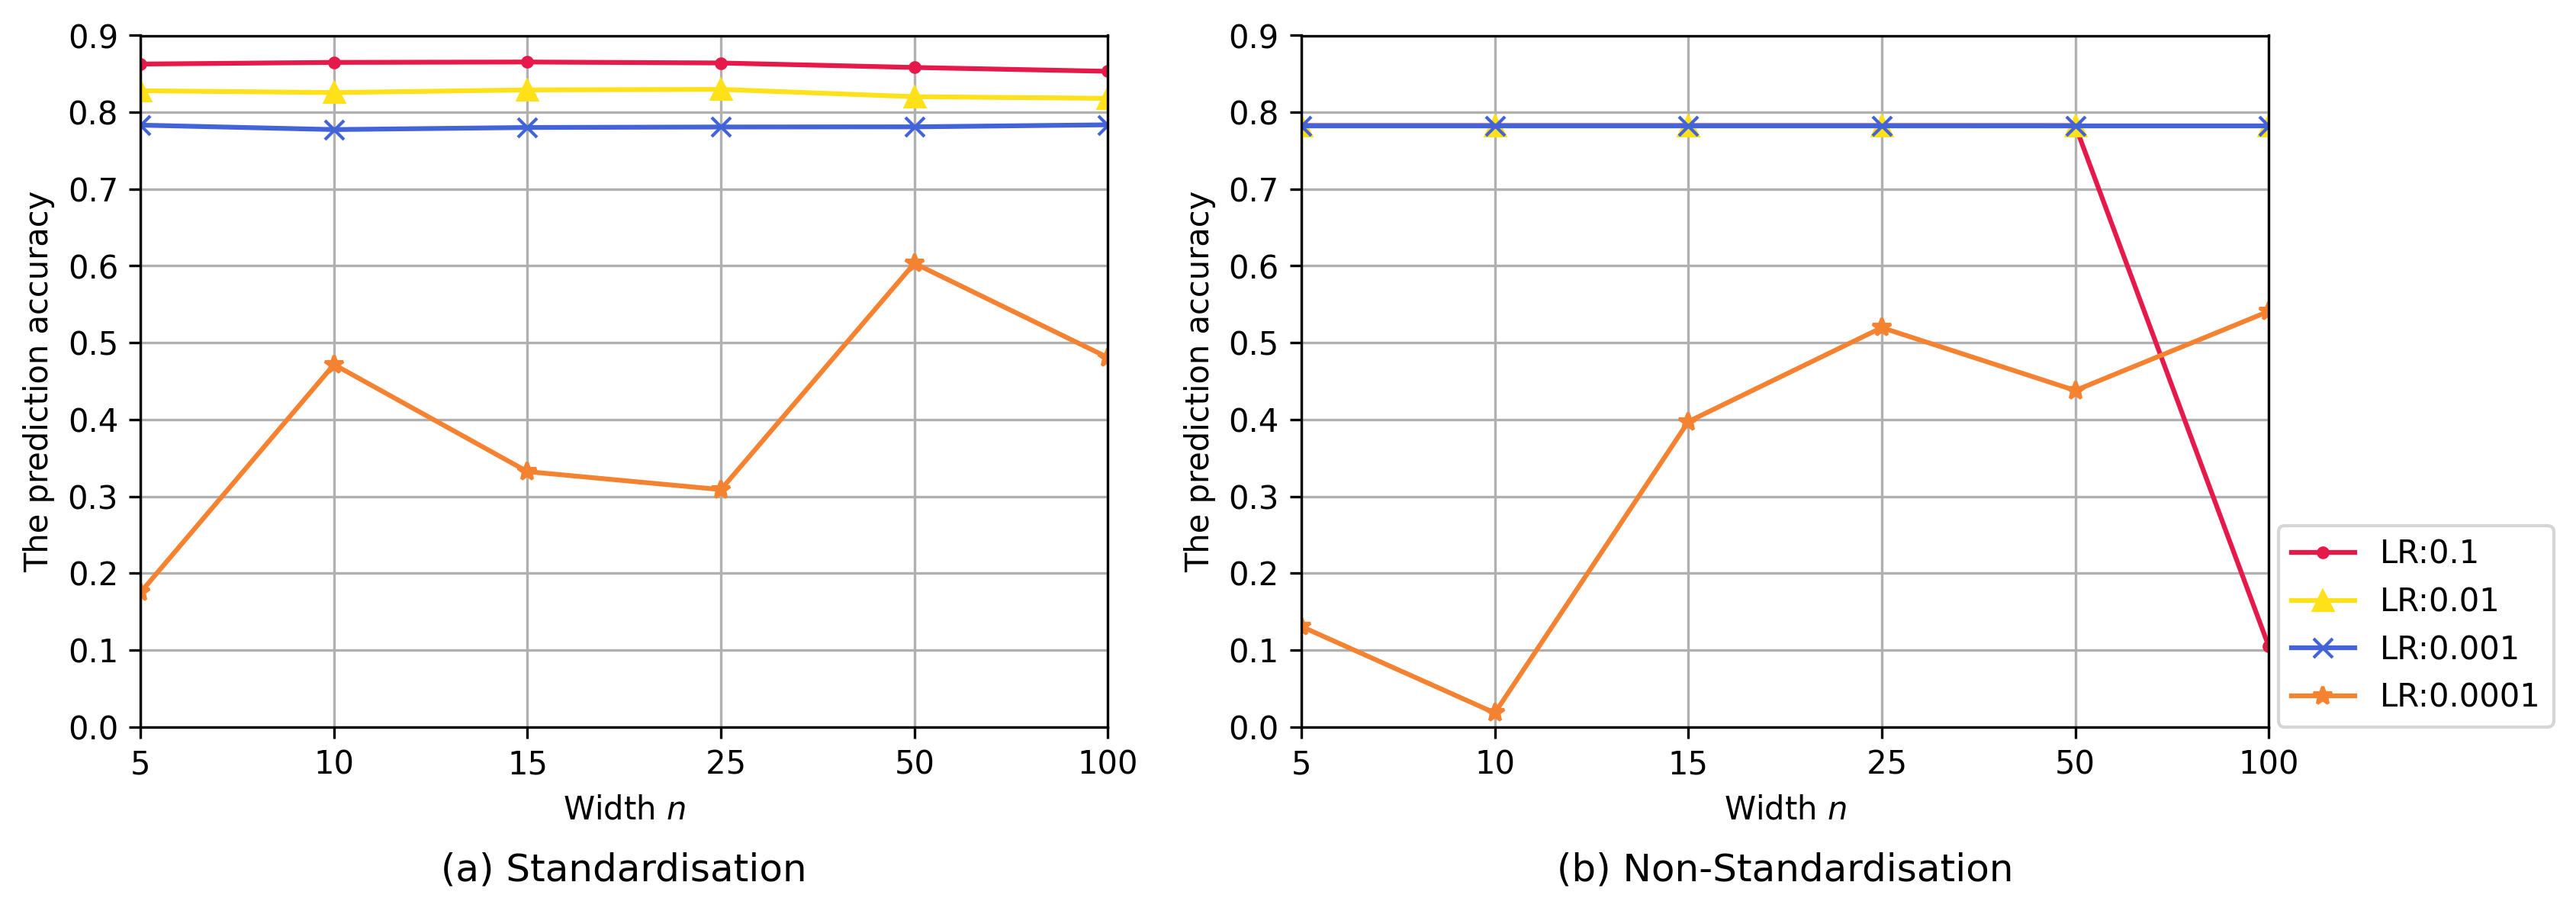

In [15]:
color=['#e6194B','#ffe119', '#4363d8', '#f58231', '#42d4f4', '#f032e6', 
       '#fabed4', '#469990', '#dcbeff', '#9A6324', '#fffac8', '#800000', '#aaffc3', '#000075']
linestyle=['.-','^-','x-','*-']

plt.figure(dpi=300,figsize=(12,4))

plt.subplot(121)
plt.ylim(ymax=0.9,ymin=0)
plt.xlim(0,len(n_hidden_list)-1)
for i in range(len(learning_rate_list)):
    plt.plot(range(len(n_hidden_list)),accuracy_test1[i],linestyle[i],c=color[i],label=f'LR:{learning_rate_list[i]}')
plt.xticks(range(len(n_hidden_list)),['5','10','15',' 25', '50', '100'])


plt.grid(True)
plt.xlabel(f'Width $n$')
plt.ylabel('The prediction accuracy')
plt.title('(a) Standardisation',y=-0.25)

plt.subplot(122)
plt.ylim(ymax=0.9,ymin=0)
plt.xlim(0,len(n_hidden_list)-1)
for i in range(len(learning_rate_list)):
    plt.plot(range(len(n_hidden_list)),accuracy_test2[i],linestyle[i],c=color[i],label=f'LR:{learning_rate_list[i]}')

plt.xticks(range(len(n_hidden_list)),['5','10','15',' 25', '50', '100'])
# plt.yticks(np.arange(0,1.1,0.1),np.arange(0,1.1,0.1))
plt.legend(
   bbox_to_anchor=(1.01, 0), loc=3, borderaxespad=0,

)
plt.xlabel(f'Width $n$')
plt.ylabel('The prediction accuracy')
plt.grid(True)
plt.title('(b) Non-Standardisation',y=-0.25)

plt.savefig('image\\hp_test.png',bbox_inches='tight')

So we use 0.1 learning rate and 15 hidden units, and use standardised dataset.

In [120]:
data=data_stand

In [13]:
# revise the defualt hyperparameter and reload the package for the training
import importlib
importlib.reload(nn)

<module 'nn' from 'J:\\term3\\dissertation\\nn.py'>

## Train RE-BNNs

In [59]:
# split the data by years
data2005=data[data.Year==2005].sort_values(by=['Mode','Household_region']).reset_index(drop=True)
data2006=data[data.Year==2006].sort_values(by=['Mode','Household_region']).reset_index(drop=True)
data2007=data[data.Year==2007].sort_values(by=['Mode','Household_region']).reset_index(drop=True)
data2008=data[data.Year==2008].sort_values(by=['Mode','Household_region']).reset_index(drop=True)
data2009=data[data.Year==2009].sort_values(by=['Mode','Household_region']).reset_index(drop=True)
data2010=data[data.Year==2010].sort_values(by=['Mode','Household_region']).reset_index(drop=True)
data2011=data[data.Year==2011].sort_values(by=['Mode','Household_region']).reset_index(drop=True)
data2012=data[data.Year==2012].sort_values(by=['Mode','Household_region']).reset_index(drop=True)
data2013=data[data.Year==2013].sort_values(by=['Mode','Household_region']).reset_index(drop=True)
data2014=data[data.Year==2014].sort_values(by=['Mode','Household_region']).reset_index(drop=True)
data2015=data[data.Year==2015].sort_values(by=['Mode','Household_region']).reset_index(drop=True)
data2016=data[data.Year==2016].sort_values(by=['Mode','Household_region']).reset_index(drop=True)

data_list=[data2005,data2006,data2007,data2008,data2009,data2010,data2011,data2012,data2013,data2014,data2015,data2016]

Train the models and extract the random effect parameters (non-standard and standard) of alteratives for each regions into lists.

In [6]:
for _ in range(50):
    accuracy_rebnn=[]
    prob_rebnn_pre=[]
    prob_rebnn_true=[]
    result_para_rebnn=[]
    qb_r_standard=[]
    year=2005
    for j in data_list:
        Test_accuracy,probabilities_pre,probabilities_true,result_para=nn.REBNN_MODEL(j,f'data_rebnn{year}time{_+1}')
        accuracy_rebnn.append(Test_accuracy)
        prob_rebnn_pre.append(probabilities_pre)
        prob_rebnn_true.append(probabilities_true)
        result_para_rebnn.append(result_para)
        #standardise the parameters of the random effect variable 
        scaler = preprocessing.StandardScaler().fit(result_para[4])
        qb_r_standard.append(scaler.transform(result_para[4]))
        year+=1

    pd.DataFrame(accuracy_rebnn).to_csv(f'results\\rebnn\\train{_+1}\\accuracy_rebnn.csv')
    for i in range(len(years_str)):
        pd.DataFrame(prob_rebnn_pre[i]).to_csv(f'results\\rebnn\\train{_+1}\\prob_rebnn_pre{years_str[i]}.csv')
        pd.DataFrame(prob_rebnn_true[i]).to_csv(f'results\\rebnn\\train{_+1}\\prob_rebnn_true{years_str[i]}.csv')
        for j in range(len(result_para_rebnn[i])):
            pd.DataFrame(result_para_rebnn[i][j]).to_csv(f'results\\rebnn\\train{_+1}\\result_para_rebnn{i}{j}.csv')
        pd.DataFrame(qb_r_standard[i]).to_csv(f'results\\rebnn\\train{_+1}\\qb_r_standard{years_str[i]}.csv')

Start training RE-BNN data_rebnn2005time41.
Start training RE-BNN data_rebnn2006time41.
Start training RE-BNN data_rebnn2007time41.
Start training RE-BNN data_rebnn2008time41.
Start training RE-BNN data_rebnn2009time41.
Start training RE-BNN data_rebnn2010time41.
Start training RE-BNN data_rebnn2011time41.
Start training RE-BNN data_rebnn2012time41.
Start training RE-BNN data_rebnn2013time41.
Start training RE-BNN data_rebnn2014time41.
Start training RE-BNN data_rebnn2015time41.
Start training RE-BNN data_rebnn2016time41.
Start training RE-BNN data_rebnn2005time42.
Start training RE-BNN data_rebnn2006time42.
Start training RE-BNN data_rebnn2007time42.
Start training RE-BNN data_rebnn2008time42.
Start training RE-BNN data_rebnn2009time42.
Start training RE-BNN data_rebnn2010time42.
Start training RE-BNN data_rebnn2011time42.
Start training RE-BNN data_rebnn2012time42.
Start training RE-BNN data_rebnn2013time42.
Start training RE-BNN data_rebnn2014time42.
Start training RE-BNN data_rebnn

# Compared against BNN, DNN, and MNL models

## Bayesian Neural Network (BNN)

The BNN uses the same hyperparameters with RE-BNN.

In [6]:
for _ in range(20,40):
    accuracy_bnn=[]
    prob_bnn_pre=[]
    result_para_bnn=[]
    year=2005
    for j in data_list:
        Test_accuracy,probabilities_pre,result_para=nn.BNN_MODEL(j,f'data_bnn{year}time{_+1}')
        accuracy_bnn.append(Test_accuracy)
        prob_bnn_pre.append(probabilities_pre)
        result_para_bnn.append(result_para)
        year+=1

    pd.DataFrame(accuracy_bnn).to_csv(f'results\\bnn\\train{_+1}\\accuracy_bnn.csv')
    for i in range(len(years_str)):
        pd.DataFrame(prob_bnn_pre[i]).to_csv(f'results\\bnn\\train{_+1}\\prob_bnn_pre{years_str[i]}.csv')
        for j in range(len(result_para_bnn[i])):
            pd.DataFrame(result_para_bnn[i][j]).to_csv(f'results\\bnn\\train{_+1}\\result_para_bnn{i}{j}.csv')

Start training BNNdata_bnn2005time21.
Start training BNNdata_bnn2006time21.
Start training BNNdata_bnn2007time21.
Start training BNNdata_bnn2008time21.
Start training BNNdata_bnn2009time21.
Start training BNNdata_bnn2010time21.
Start training BNNdata_bnn2011time21.
Start training BNNdata_bnn2012time21.
Start training BNNdata_bnn2013time21.
Start training BNNdata_bnn2014time21.
Start training BNNdata_bnn2015time21.
Start training BNNdata_bnn2016time21.
Start training BNNdata_bnn2005time22.
Start training BNNdata_bnn2006time22.
Start training BNNdata_bnn2007time22.
Start training BNNdata_bnn2008time22.
Start training BNNdata_bnn2009time22.
Start training BNNdata_bnn2010time22.
Start training BNNdata_bnn2011time22.
Start training BNNdata_bnn2012time22.
Start training BNNdata_bnn2013time22.
Start training BNNdata_bnn2014time22.
Start training BNNdata_bnn2015time22.
Start training BNNdata_bnn2016time22.
Start training BNNdata_bnn2005time23.
Start training BNNdata_bnn2006time23.
Start traini

Start training BNNdata_bnn2005time39.
Start training BNNdata_bnn2006time39.
Start training BNNdata_bnn2007time39.
Start training BNNdata_bnn2008time39.
Start training BNNdata_bnn2009time39.
Start training BNNdata_bnn2010time39.
Start training BNNdata_bnn2011time39.
Start training BNNdata_bnn2012time39.
Start training BNNdata_bnn2013time39.
Start training BNNdata_bnn2014time39.
Start training BNNdata_bnn2015time39.
Start training BNNdata_bnn2016time39.
Start training BNNdata_bnn2005time40.
Start training BNNdata_bnn2006time40.
Start training BNNdata_bnn2007time40.
Start training BNNdata_bnn2008time40.
Start training BNNdata_bnn2009time40.
Start training BNNdata_bnn2010time40.
Start training BNNdata_bnn2011time40.
Start training BNNdata_bnn2012time40.
Start training BNNdata_bnn2013time40.
Start training BNNdata_bnn2014time40.
Start training BNNdata_bnn2015time40.
Start training BNNdata_bnn2016time40.


## Fully Connected Neural Network (DNN)

### Hyperparameter searching for DNN

In [125]:
# find the best parameter
# Hyperparameter spaces is as same as RE-BNN except batchsize

learning_rate_list=[0.1,0.01, 1e-3, 1e-4]
n_hidden_list=[5,10,15, 25, 50, 100]
batch_size_list=[10,50,100]

data_test1=data_stand.sample(100000,random_state=42)
data_test1.reset_index(inplace=True)
accuracy_test1_dnn=np.zeros((len(learning_rate_list), len(n_hidden_list),len(batch_size_list))) 
for i in range(len(learning_rate_list)):
    for j in range(len(n_hidden_list)):
        for k in range(len(batch_size_list)):
            Test_accuracy,probabilities,result_para=nn.DNN_MODEL(data_test1,f'searching{i}{j}{k}',n_hidden=n_hidden_list[j],learning_rate=learning_rate_list[i],batch_size=batch_size_list[k])
            accuracy_test1_dnn[i][j][k]=Test_accuracy

data_test2=data_non_stand.sample(100000,random_state=42)
data_test2.reset_index(inplace=True)
accuracy_test2_dnn=np.zeros((len(learning_rate_list), len(n_hidden_list),len(batch_size_list)))

for i in range(len(learning_rate_list)):
    for j in range(len(n_hidden_list)):
        for k in range(len(batch_size_list)):
            Test_accuracy,probabilities, result_para=nn.DNN_MODEL(data_test2,,f'searching{i}{j}{k}',n_hidden=n_hidden_list[j],learning_rate=learning_rate_list[i],batch_size=batch_size_list[k])
            accuracy_test2_dnn[i][j][k]=Test_accuracy

#save the test results
for i in range(len(learning_rate_list)):
    pd.DataFrame(accuracy_test1_dnn[i]).to_csv(f'parameter\\hp_searching_stand_lr{learning_rate_list[i]}.csv')
    pd.DataFrame(accuracy_test2_dnn[i]).to_csv(f'parameter\\hp_searching_nonstand_lr{learning_rate_list[i]}.csv')

Start training DNN.
Start training DNN.
Start training DNN.
Start training DNN.
Start training DNN.
Start training DNN.
Start training DNN.
Start training DNN.
Start training DNN.
Start training DNN.
Start training DNN.
Start training DNN.
Start training DNN.
Start training DNN.
Start training DNN.
Start training DNN.
Start training DNN.
Start training DNN.
Start training DNN.
Start training DNN.
Start training DNN.
Start training DNN.
Start training DNN.
Start training DNN.
Start training DNN.
Start training DNN.
Start training DNN.
Start training DNN.
Start training DNN.
Start training DNN.
Start training DNN.
Start training DNN.
Start training DNN.
Start training DNN.
Start training DNN.
Start training DNN.
Start training DNN.
Start training DNN.
Start training DNN.
Start training DNN.
Start training DNN.
Start training DNN.
Start training DNN.
Start training DNN.
Start training DNN.
Start training DNN.
Start training DNN.
Start training DNN.
Start training DNN.
Start training DNN.


In [8]:
learning_rate_list=[0.1,0.01, 1e-3, 1e-4]
n_hidden_list=[5,10,15, 25, 50, 100]
batch_size_list=[10,50,100]

# read the accuracy results from local
accuracy_test1_dnn=np.zeros((len(learning_rate_list), len(n_hidden_list),len(batch_size_list))) 
accuracy_test2_dnn=np.zeros((len(learning_rate_list), len(n_hidden_list),len(batch_size_list)))
for i in range(len(learning_rate_list)):
    accuracy_test1_dnn[i]=pd.read_csv(f'parameter\\hp_searching_stand_lr{learning_rate_list[i]}.csv',index_col=0).values
    accuracy_test2_dnn[i]=pd.read_csv(f'parameter\\hp_searching_nonstand_lr{learning_rate_list[i]}.csv',index_col=0).values

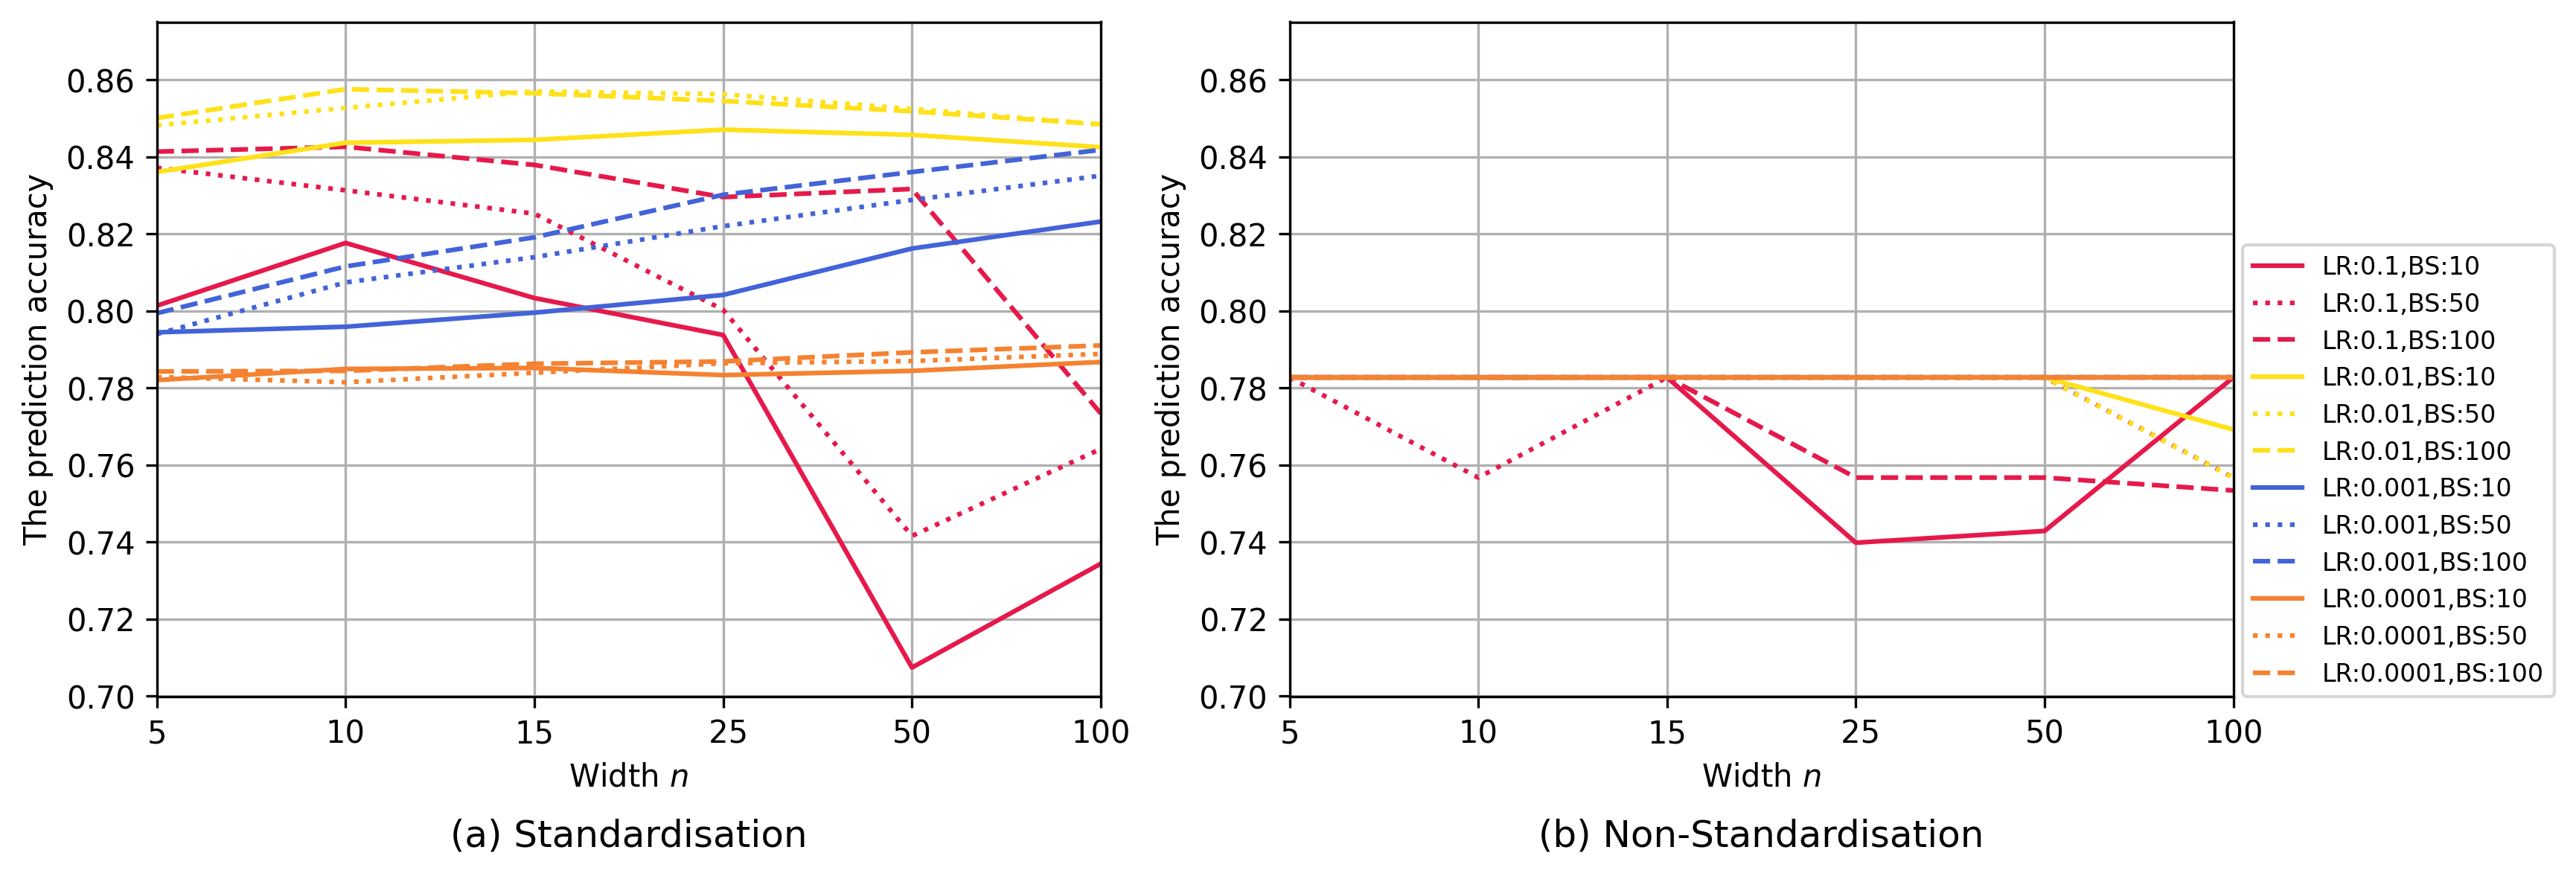

In [14]:
color=['#e6194B','#ffe119', '#4363d8', '#f58231', '#42d4f4', '#f032e6', 
       '#fabed4', '#469990', '#dcbeff', '#9A6324', '#fffac8', '#800000', '#aaffc3', '#000075']
# linestyle=['.-','^-','x-','*-']

# color= ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd']
linestyle_batch=['-',':','--']

plt.figure(dpi=300,figsize=(12,4))

plt.subplot(121)
plt.xlim(0,len(n_hidden_list)-1)
plt.ylim(0.7,0.875)

for i in range(len(learning_rate_list)):
    for k in range(len(batch_size_list)):
        plt.plot(range(len(n_hidden_list)),accuracy_test1_dnn[i].T[k],
                 c=color[i],linestyle=linestyle_batch[k],
                 #alpha=0.8,
                 label=f'LR:{learning_rate_list[i]}Batch:{batch_size_list[k]}')
#         for j in range(len(accuracy_test1_dnn[i])):
#             plt.text(range(len(n_hidden_list))[j],accuracy_test1_dnn[i][j][k],str(round(accuracy_test1_dnn[i][j][k],3)))
plt.xticks(range(len(n_hidden_list)),['5','10','15',' 25', '50', '100'])

# plt.legend()
plt.grid(True)
plt.xlabel(f'Width $n$')
plt.ylabel('The prediction accuracy')
plt.title('(a) Standardisation',y=-0.25)

plt.subplot(122)
plt.xlim(0,len(n_hidden_list)-1)
plt.ylim(0.7,0.875)

for i in range(len(learning_rate_list)):
    for k in range(len(batch_size_list)):
        plt.plot(range(len(n_hidden_list)),accuracy_test2_dnn[i].T[k],
                 c=color[i],linestyle=linestyle_batch[k],
               #  alpha=0.8,
                 label=f'LR:{learning_rate_list[i]},BS:{batch_size_list[k]}')
#         for j in range(len(accuracy_test2_dnn[i])):
#             plt.text(range(len(n_hidden_list))[j],accuracy_test2_dnn[i][j][k],str(round(accuracy_test2_dnn[i][j][k],3)))
plt.xticks(range(len(n_hidden_list)),['5','10','15',' 25', '50', '100'])

plt.legend(
   bbox_to_anchor=(1.01, 0), loc=3, borderaxespad=0,
    prop = {'size':8}
)
plt.grid(True)
plt.xlabel(f'Width $n$')
plt.ylabel('The prediction accuracy')
plt.title('(b) Non-Standardisation',y=-0.25)

plt.savefig('image\\hp_test_dnn.png',bbox_inches='tight')

Therefore,the hyperparameters we used to train DNN is LR:0.01,BS:100,width_n=10,standardisation=Ture

### Train DNNs

In [6]:
for _ in range(50):
    accuracy_dnn=[]
    prob_dnn_pre=[]
    result_para_dnn=[]
    year=2005
    for j in data_list:
        Test_accuracy,probabilities_pre,result_para=nn.DNN_MODEL(j,f'data_dnn{year} time{_+1}')
        accuracy_dnn.append(Test_accuracy)
        prob_dnn_pre.append(probabilities_pre)
        result_para_dnn.append(result_para)
        year+=1

    pd.DataFrame(accuracy_dnn).to_csv(f'results\\dnn\\train{_+1}\\accuracy_dnn.csv')
    for i in range(len(years_str)):
        pd.DataFrame(prob_dnn_pre[i]).to_csv(f'results\\dnn\\train{_+1}\\prob_dnn_pre{years_str[i]}.csv')
        for j in range(len(result_para_dnn[i])):
            pd.DataFrame(result_para_dnn[i][j]).to_csv(f'results\\dnn\\train{_+1}\\result_para_dnn{i}{j}.csv')

Start training DNN for data_dnn2005 time47
Start training DNN for data_dnn2006 time47
Start training DNN for data_dnn2007 time47
Start training DNN for data_dnn2008 time47
Start training DNN for data_dnn2009 time47
Start training DNN for data_dnn2010 time47
Start training DNN for data_dnn2011 time47
Start training DNN for data_dnn2012 time47
Start training DNN for data_dnn2013 time47
Start training DNN for data_dnn2014 time47
Start training DNN for data_dnn2015 time47
Start training DNN for data_dnn2016 time47
Start training DNN for data_dnn2005 time48
Start training DNN for data_dnn2006 time48
Start training DNN for data_dnn2007 time48
Start training DNN for data_dnn2008 time48
Start training DNN for data_dnn2009 time48
Start training DNN for data_dnn2010 time48
Start training DNN for data_dnn2011 time48
Start training DNN for data_dnn2012 time48
Start training DNN for data_dnn2013 time48
Start training DNN for data_dnn2014 time48
Start training DNN for data_dnn2015 time48
Start train

KeyboardInterrupt: 

## Multinomial Logit Model (MNL)

In [117]:
corr_choice_attribute=pd.DataFrame(columns=plot.get_modes(),index=nn.get_vars())

In [155]:
importlib.reload(nn)
# choose vars of each mode
data_test_mnl=data.sample(100000,random_state=42).reset_index()
data_test_mnl.drop(columns=['index','IndividualID','HouseholdID','Year','Household_region'],inplace=True)
mnl_col,corr_mnl=nn.get_vars_MNL(data_test_mnl)

Columns correlated with the alternatives Walk:
Mode_y                 1.000000
Household_car          0.128122
Trip_distance          0.119677
Household_licence      0.104553
Trip_purpose_1         0.073007
Trip_purpose_6         0.060728
Trip_purpose_2         0.054624
Household_employeed    0.049424
Individual_income      0.048711
Trip_purpose_3         0.044048
Name: Mode_y, dtype: float64
Columns selected in the utility function of Walk:
['Household_car', 'Trip_distance', 'Household_licence', 'Trip_time']
 
Columns correlated with the alternatives Bicycle:
Mode_y                    1.000000
Household_bike            0.077892
Trip_purpose_1            0.069661
Individual_gender_1       0.063832
Household_car             0.059819
Trip_distance             0.039636
Individual_age            0.029392
Household_licence         0.028681
Trip_purpose_4            0.027300
Individual_education_1    0.023555
Name: Mode_y, dtype: float64
Columns selected in the utility function of Bicycle:
[

In [160]:
for i in range(len(plot.get_modes())):
    corr_choice_attribute[plot.get_modes()[i]]=corr_mnl.T[i]

In [161]:
corr_choice_attribute

Walk   Bicycle  Car or van       Bus      Rail
Trip_distance          -0.119677 -0.039636    0.046684 -0.041080  0.163098
Trip_time               0.020177 -0.010571   -0.168562  0.078837  0.238121
Household_employeed    -0.049424  0.013772    0.048696 -0.056664  0.033098
Household_children     -0.006015 -0.000849    0.035491 -0.036228 -0.020687
Household_bike         -0.032384  0.077892    0.072615 -0.099146 -0.035847
Household_car          -0.128122 -0.059819    0.284203 -0.229097 -0.082231
Household_licence      -0.104553 -0.028681    0.222658 -0.215844 -0.025185
Individual_age         -0.041587 -0.029392    0.120671 -0.074792 -0.079956
Individual_income      -0.048711  0.009308    0.038001 -0.089951  0.099691
Population_density      0.015336  0.020829   -0.231872  0.153816  0.265060
Trip_purpose_1         -0.073007  0.069661   -0.059579  0.036851  0.144623
Trip_purpose_2         -0.054624 -0.008930    0.038476 -0.029605  0.044920
Trip_purpose_3          0.044048 -0.004637   -0.061349  0.060387 -0.008838
Trip_purpose_4         -0.010413 -0.027300    0.025219  0.038156 -0.066645
Trip_purpose_5         -0.015676 -0.015613    0.026738  0.006924 -0.030863
Trip_purpose_6         -0.060728  0.011233    0.066028 -0.030777 -0.017263
Household_settlement_1  0.043782  0.020292   -0.114717  0.082647  0.060377
Individual_education_1 -0.006266  0.023555   -0.027694 -0.044807  0.108496
Individual_gender_1    -0.017754  0.063832   -0.004860 -0.034235  0.035892

In [162]:
corr_choice_attribute.to_csv('results\\corr_choice_attribute.csv')

In [ ]:
# calibrate the model
accuracy_mnl=[]
prob_mnl_pre=[]
for i in data_list:
    acc,pred=nn.MNL_MODEL(i,mnl_col)
    accuracy_mnl.append(acc)
    prob_mnl_pre.append(pred)
    
pd.DataFrame(accuracy_mnl).to_csv('results\\mnl\\accuracy_mnl.csv')
for i in range(len(years_str)):
    pd.DataFrame(prob_mnl_pre[i]).to_csv(f'results\\mnl\\prob_mnl_pre{years_str[i]}.csv')

# Results and analysis

In [2]:
#before analysis, read the training results and the parameter of each model

#rebnn
rebnn_result=analysis.training_result_rebnn()
accuracy_rebnn_50 = rebnn_result[0]
prob_rebnn_pre_50 = rebnn_result[1]
prob_rebnn_true_50 = rebnn_result[2]
result_para_rebnn_50 = rebnn_result[3]
qb_r_standard_50 = rebnn_result[4]

# bnn
bnn_result=analysis.training_result_bnn()
accuracy_bnn_50 = bnn_result[0]
prob_bnn_pre_50 = bnn_result[1]
result_para_bnn_50 = bnn_result[2]

#dnn
dnn_result=analysis.training_result_dnn()
accuracy_dnn_50 = dnn_result[0]
prob_dnn_pre_50 = dnn_result[1]
result_para_dnn_50 = dnn_result[2]

#mnl
mnl_result=analysis.training_result_mnl()
accuracy_mnl=mnl_result[0]
prob_mnl_pre=mnl_result[1]
mnl_col=mnl_result[2]

## Predictive accuracy

### Predictive performances in different year data

For each ML model, we trains 50 times.

In [16]:
print(f'The max in RE-BNN:{max(np.mean(accuracy_rebnn_50,axis=0))}')
print(f'The max in BNN:{max(np.mean(accuracy_bnn_50,axis=0))}')
print(f'The max in DNN:{max(np.mean(accuracy_dnn_50,axis=0))}')
print(f'The max in MNL:{max(accuracy_mnl.T[0])}')

The max in RE-BNN:0.8715384006500244
The max in BNN:0.8711025857925415
The max in DNN:0.8656579327583312
The max in MNL:0.7433825729753257


In [17]:
print(f'The min in RE-BNN:{min(np.mean(accuracy_rebnn_50,axis=0))}')
print(f'The min in BNN:{min(np.mean(accuracy_bnn_50,axis=0))}')
print(f'The min in DNN:{min(np.mean(accuracy_dnn_50,axis=0))}')
print(f'The min in MNL:{min(accuracy_mnl.T[0])}')

The min in RE-BNN:0.8605962276458741
The min in BNN:0.8612586224079132
The min in DNN:0.8494245862960815
The min in MNL:0.7277064538514921


Now we plot their accuracy in each year testing set. Each training result is represented by the curve with low alpha value and the avarage accuracy in each year testing set is represented by the curve with high alpha value.

In [20]:
accuracy_df=pd.DataFrame(columns=years_str)
accuracy_df.loc[0]=np.mean(accuracy_rebnn_50,axis=0)
accuracy_df.loc[1]=np.mean(accuracy_bnn_50,axis=0)
accuracy_df.loc[2]=np.mean(accuracy_dnn_50,axis=0)
accuracy_df.loc[3]=accuracy_mnl.T[0]
accuracy_df.to_csv('results\\accuracy.csv')

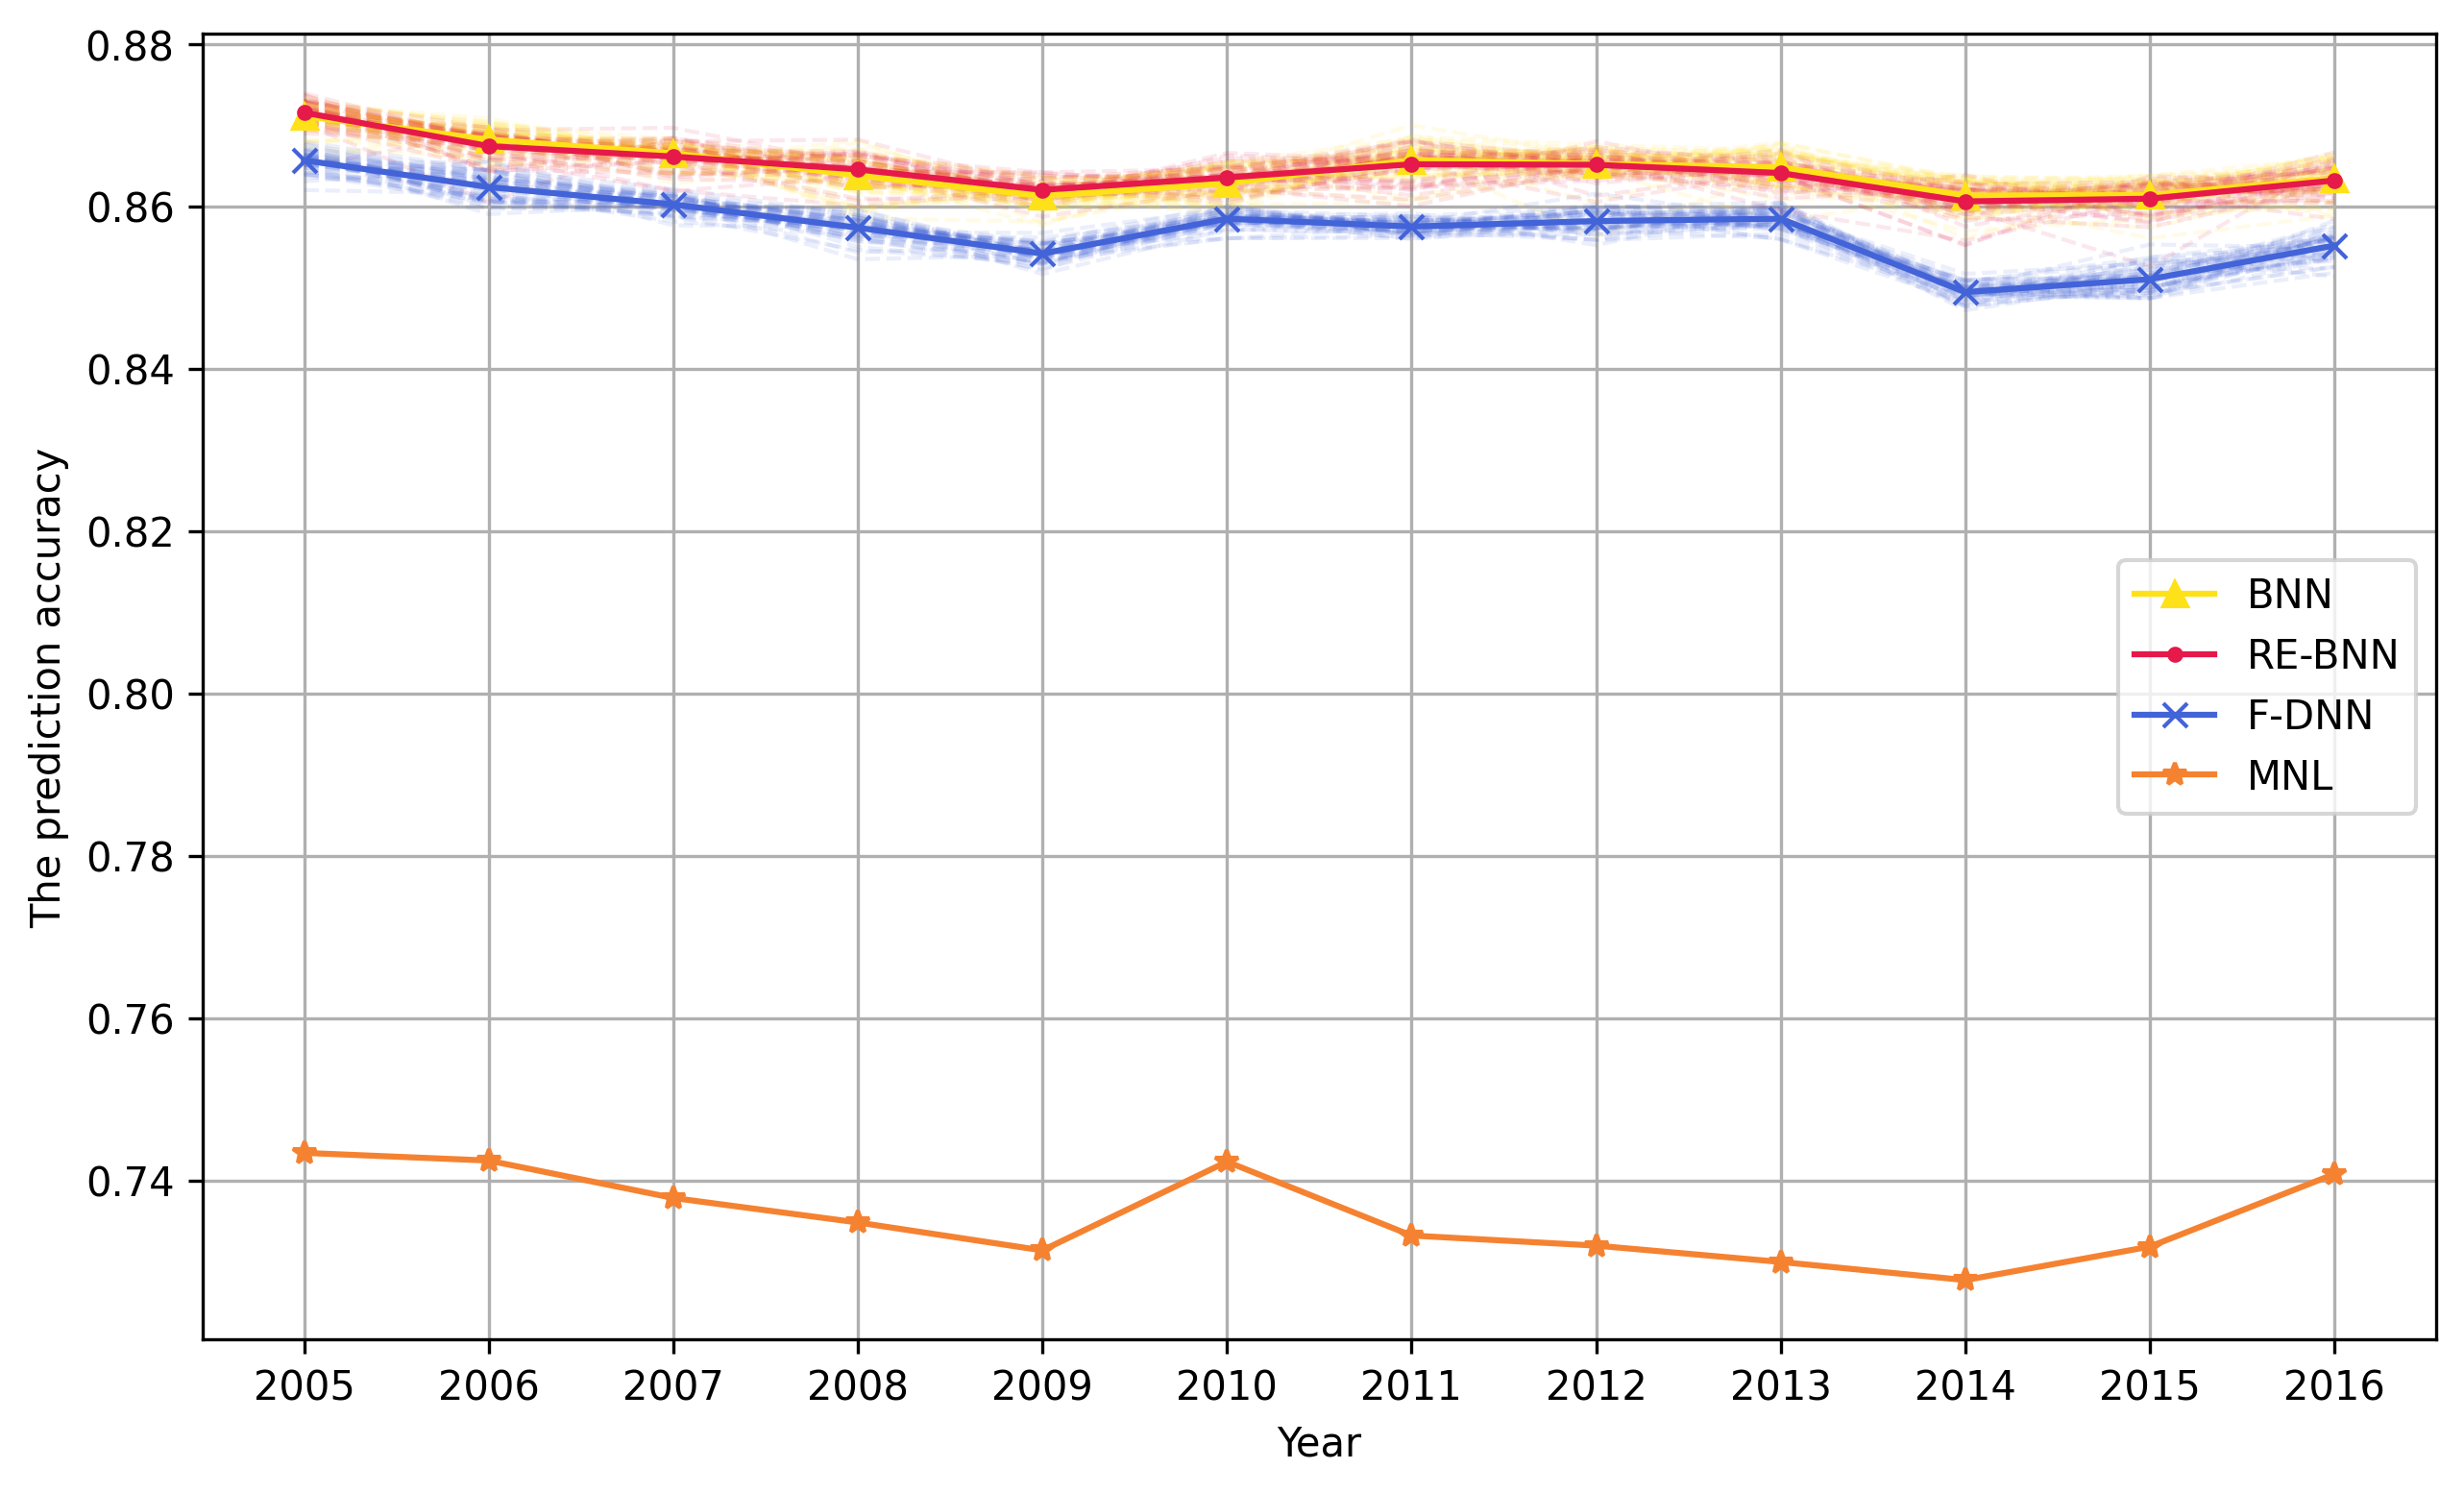

In [24]:
color=['#e6194B','#ffe119', '#4363d8', '#f58231', '#42d4f4', '#f032e6', 
       '#fabed4', '#469990', '#dcbeff', '#9A6324', '#fffac8', '#800000', '#aaffc3', '#000075']
linestyle=['.-','^-','x-','*-']

plt.figure(dpi=300,figsize=(10,6))

#print each training result
for _ in range(50):
    plt.plot(accuracy_rebnn_50[_],'--',alpha=0.1,linewidth=1,c=color[0])
    plt.plot(accuracy_bnn_50[_],'--',alpha=0.1,linewidth=1,c=color[1])
    plt.plot(accuracy_dnn_50[_],'--',alpha=0.1,linewidth=1,c=color[2])
    
#print average
plt.plot(np.mean(accuracy_bnn_50,axis=0),linestyle[1],alpha=1,label='BNN',c=color[1])
plt.plot(np.mean(accuracy_rebnn_50,axis=0),linestyle[0],alpha=1,label='RE-BNN',c=color[0])
plt.plot(np.mean(accuracy_dnn_50,axis=0),linestyle[2],alpha=1,label='F-DNN',c=color[2])
plt.plot(accuracy_mnl,linestyle[3],alpha=1,label='MNL',c=color[3])
    
plt.xticks(range(12),['2005','2006','2007','2008','2009','2010','2011','2012','2013','2014','2015','2016'])
plt.xlabel('Year')
plt.ylabel('The prediction accuracy')
plt.grid()
plt.legend()
plt.savefig('image/Comparision of the predictive performance.png',dpi=300)

### Predictive performances in different regions

We choose the result trainded by one year dataset (2016) and test the accuracy in different region.

In [39]:
import importlib
importlib.reload(analysis)

<module 'analysis' from 'J:\\term3\\dissertation\\analysis.py'>

In [41]:
# read the dataset(use to extract the region information of each observation)
data2016=analysis.dataset_year(2016)

In [46]:
year='2016'

#the ture mode choice in 2016 testing set
acc_ture=prob_rebnn_true_50[0][year]

# create three dataframes to store accucry values in different regions
acc_rebnn=pd.DataFrame(columns=plot.get_region(),index=range(50))
acc_bnn=pd.DataFrame(columns=plot.get_region(),index=range(50))
acc_dnn=pd.DataFrame(columns=plot.get_region(),index=range(50))
acc_mnl=pd.DataFrame(columns=plot.get_region())

for _ in range(50):
    acc_rebnn.loc[_]=analysis.acc_region(data2016, prob_rebnn_pre_50[_][year],acc_ture)
    acc_bnn.loc[_]=analysis.acc_region(data2016, prob_bnn_pre_50[_][year],acc_ture)
    acc_dnn.loc[_]=analysis.acc_region(data2016, prob_dnn_pre_50[_][year],acc_ture)

acc_mnl.loc[0]=analysis.acc_region(data2016, prob_mnl_pre[year],acc_ture)


In [60]:
acc_rebnn.to_csv('results\\acc_region_rebnn.csv')
acc_bnn.to_csv('results\\acc_region_bnn.csv')
acc_dnn.to_csv('results\\acc_region_dnn.csv')
acc_mnl.to_csv('results\\acc_region_mnl.csv')

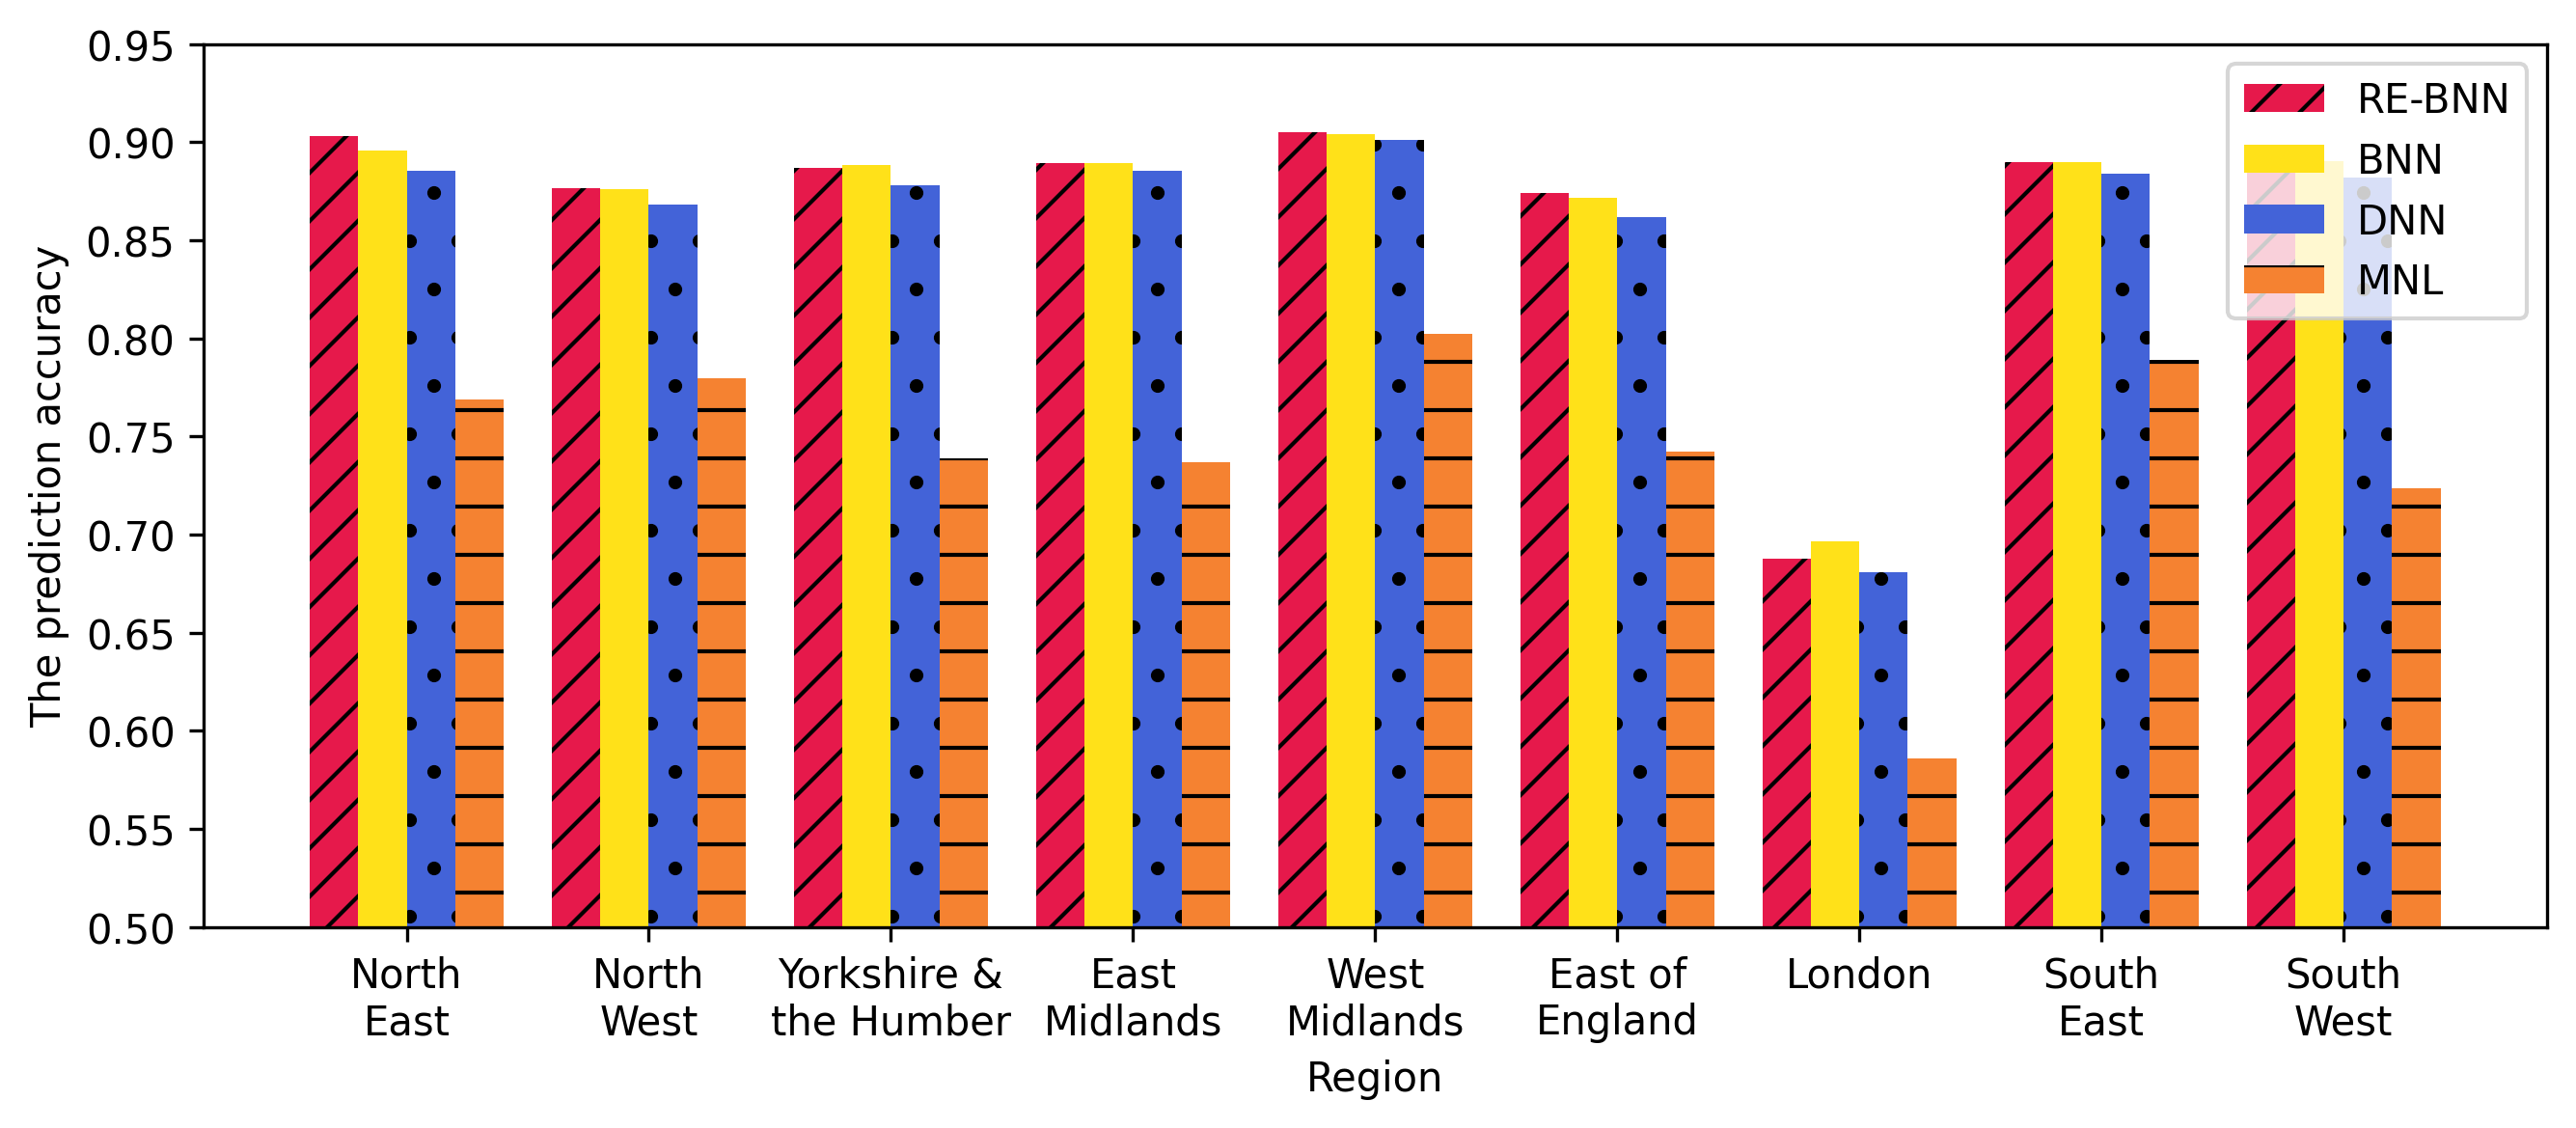

In [111]:
labels = ['North\nEast', 'North\nWest', 'Yorkshire &\nthe Humber'
        , 'East\nMidlands', 'West\nMidlands', 'East of\nEngland', 'London', 'South\nEast', 'South\nWest']
x1 = np.mean(acc_rebnn.values,axis=0)
x2 = np.mean(acc_bnn.values,axis=0)
x3=np.mean(acc_dnn.values,axis=0)
x4=acc_mnl.loc[0].values

x = np.arange(len(labels))  # the label locations
width = 0.8  # the width of the bars
color=['#e6194B','#ffe119', '#4363d8', '#f58231']
hatch=['//', '','.', '-']

fig, ax = plt.subplots(dpi=300,figsize=(9,4))
plt.ylim(0.5,0.95)
ax.bar(x - width*3/8, x1, width/4, label='RE-BNN',hatch=hatch[0],color=color[0])
ax.bar(x - width/8, x2, width/4, label='BNN',hatch=hatch[1],color=color[1])
ax.bar(x + width/8, x3, width/4, label='DNN',hatch=hatch[2],color=color[2])
ax.bar(x + width*3/8, x4, width/4, label='MNL',hatch=hatch[3],color=color[3])


plt.xlabel('Region')
plt.ylabel('The prediction accuracy')

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.savefig('image\\acc_region.png')

## Exploration of random effect parameters of different regions

Now we plot the region-sepcific parameter values for different alternatives, which can be regarded as the offset utility and be used to compare the travel mode choice preferences across regions.

### For a single year

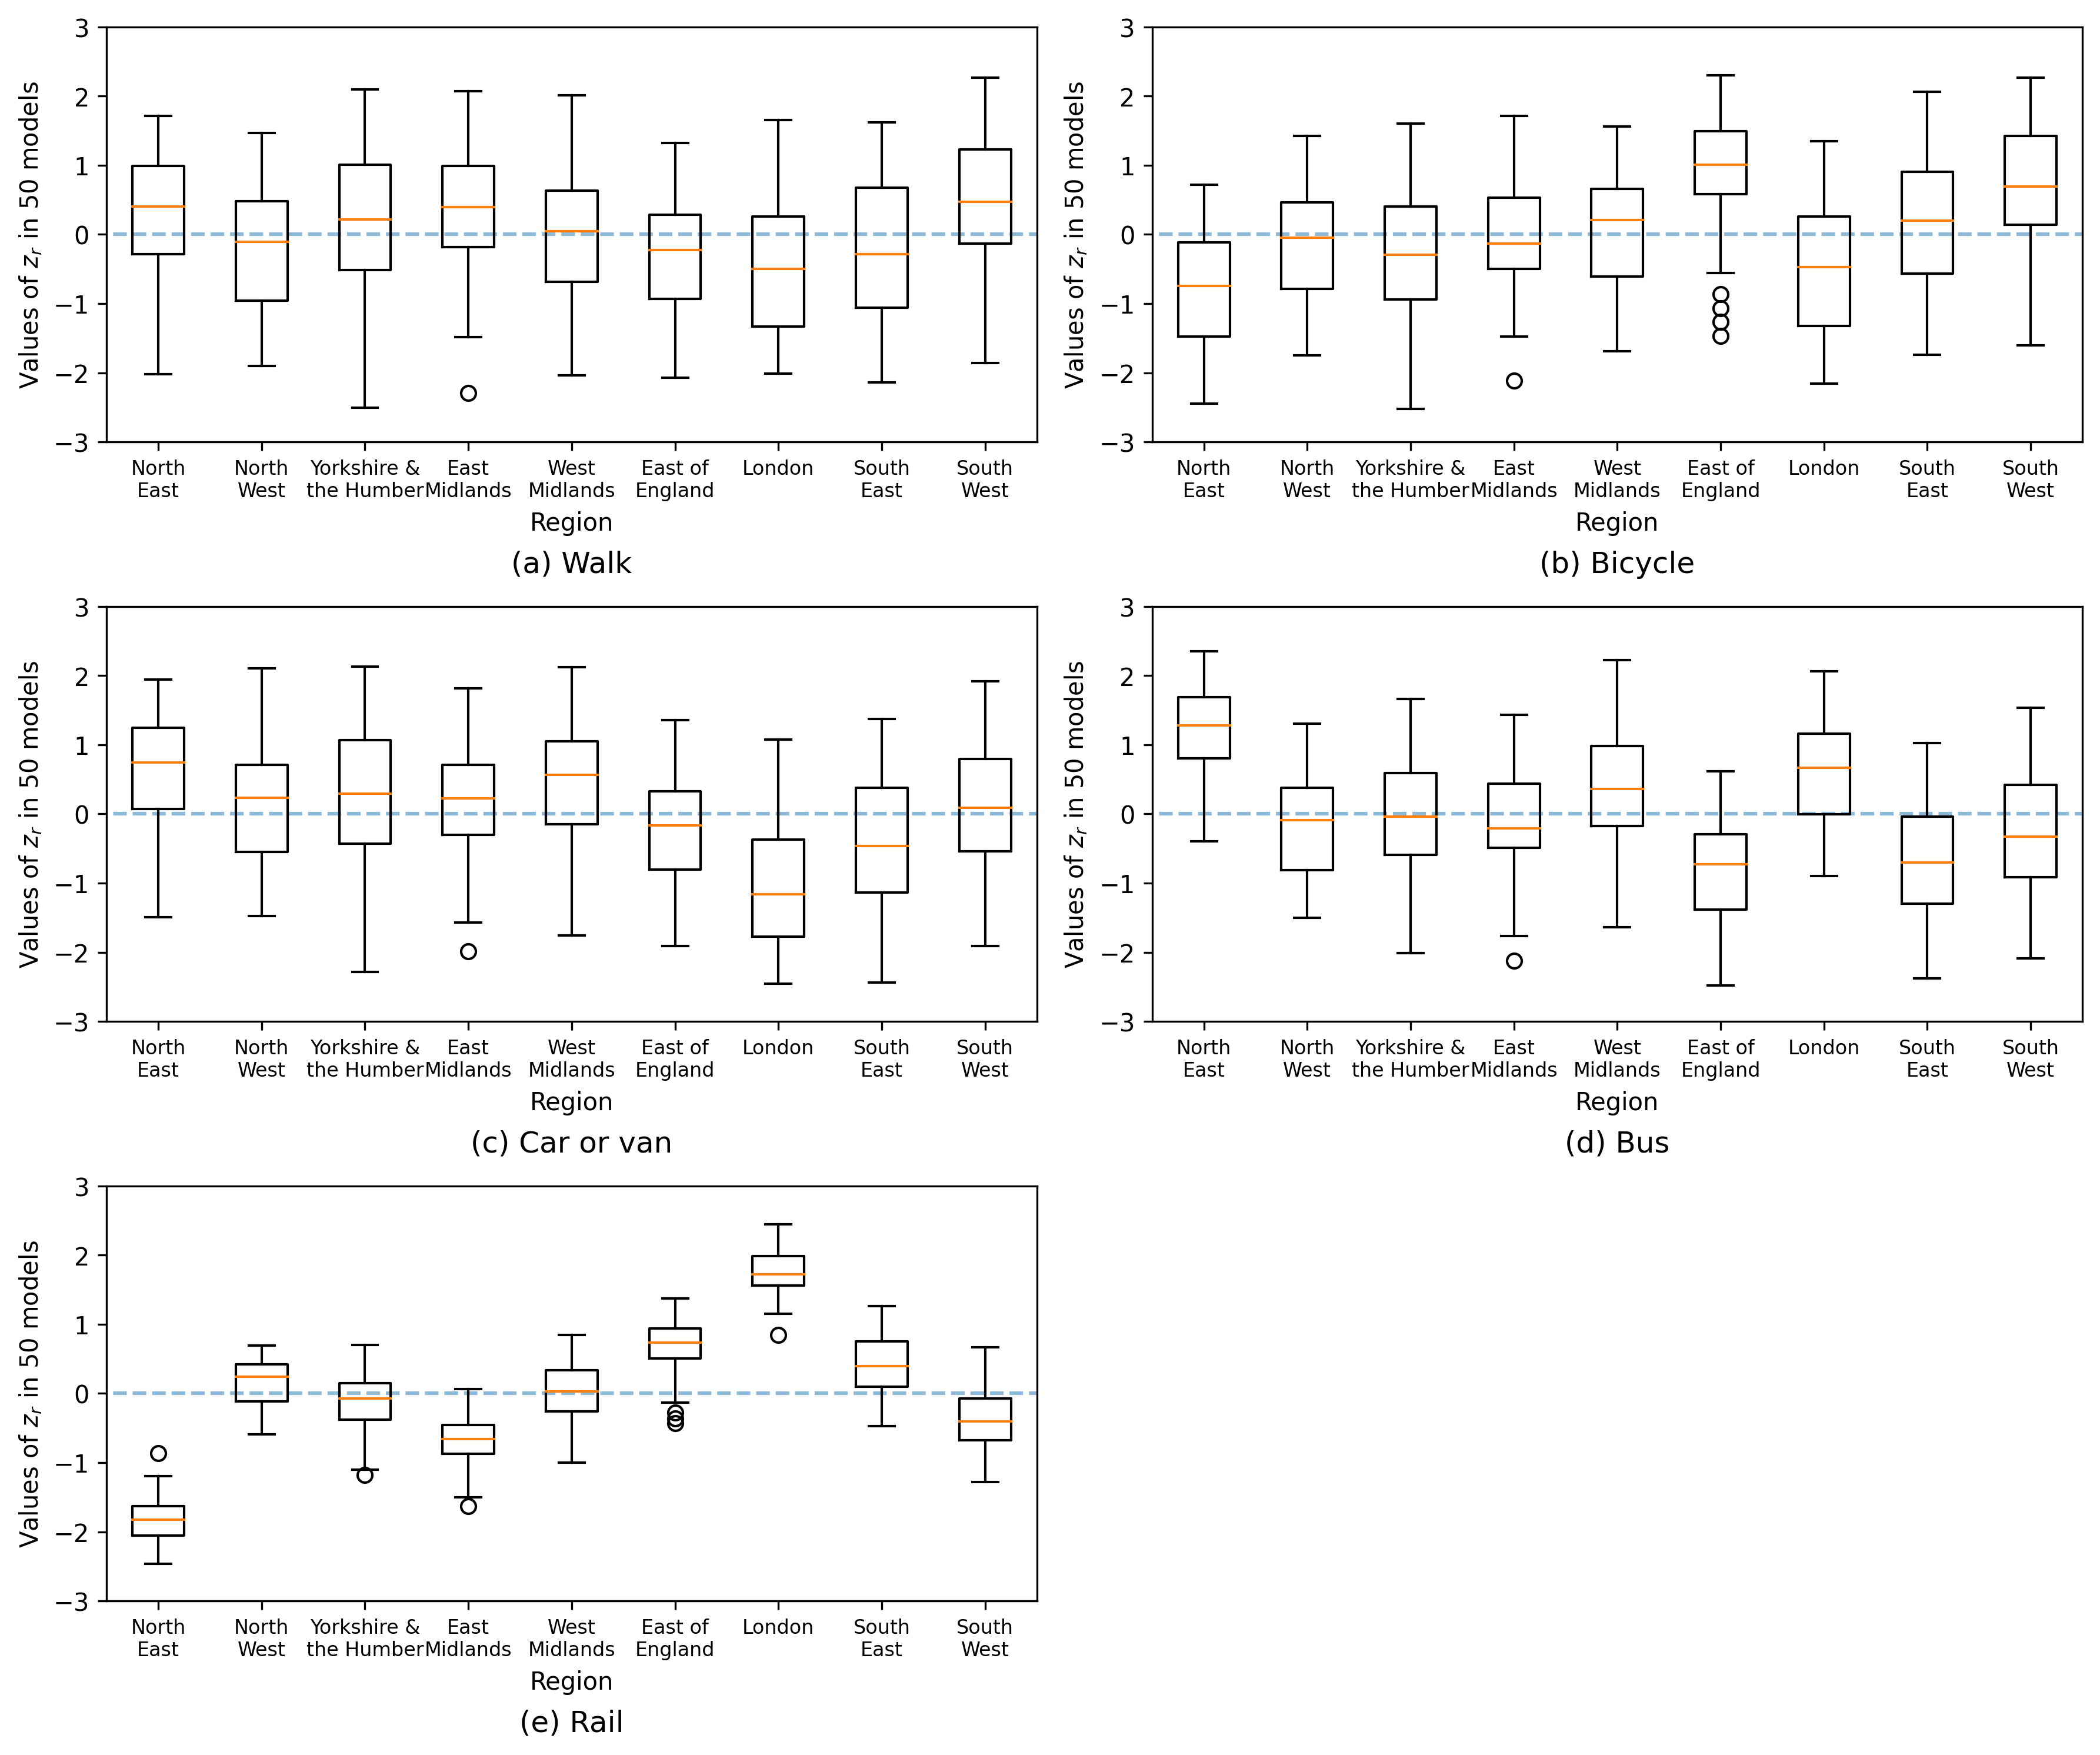

In [62]:
# plot
plot.Mode_in_Region_Plot_Stand(qb_r_standard_50,num_model=50,year='2016')
plt.savefig(f'image/Zr_stand.png', dpi=300)

### For all years

Now we use the average value (standardised) of 50 models and plot them trained by different year dataset. The length of the boxes represents the degree of variation of this alternative preference in the time period.

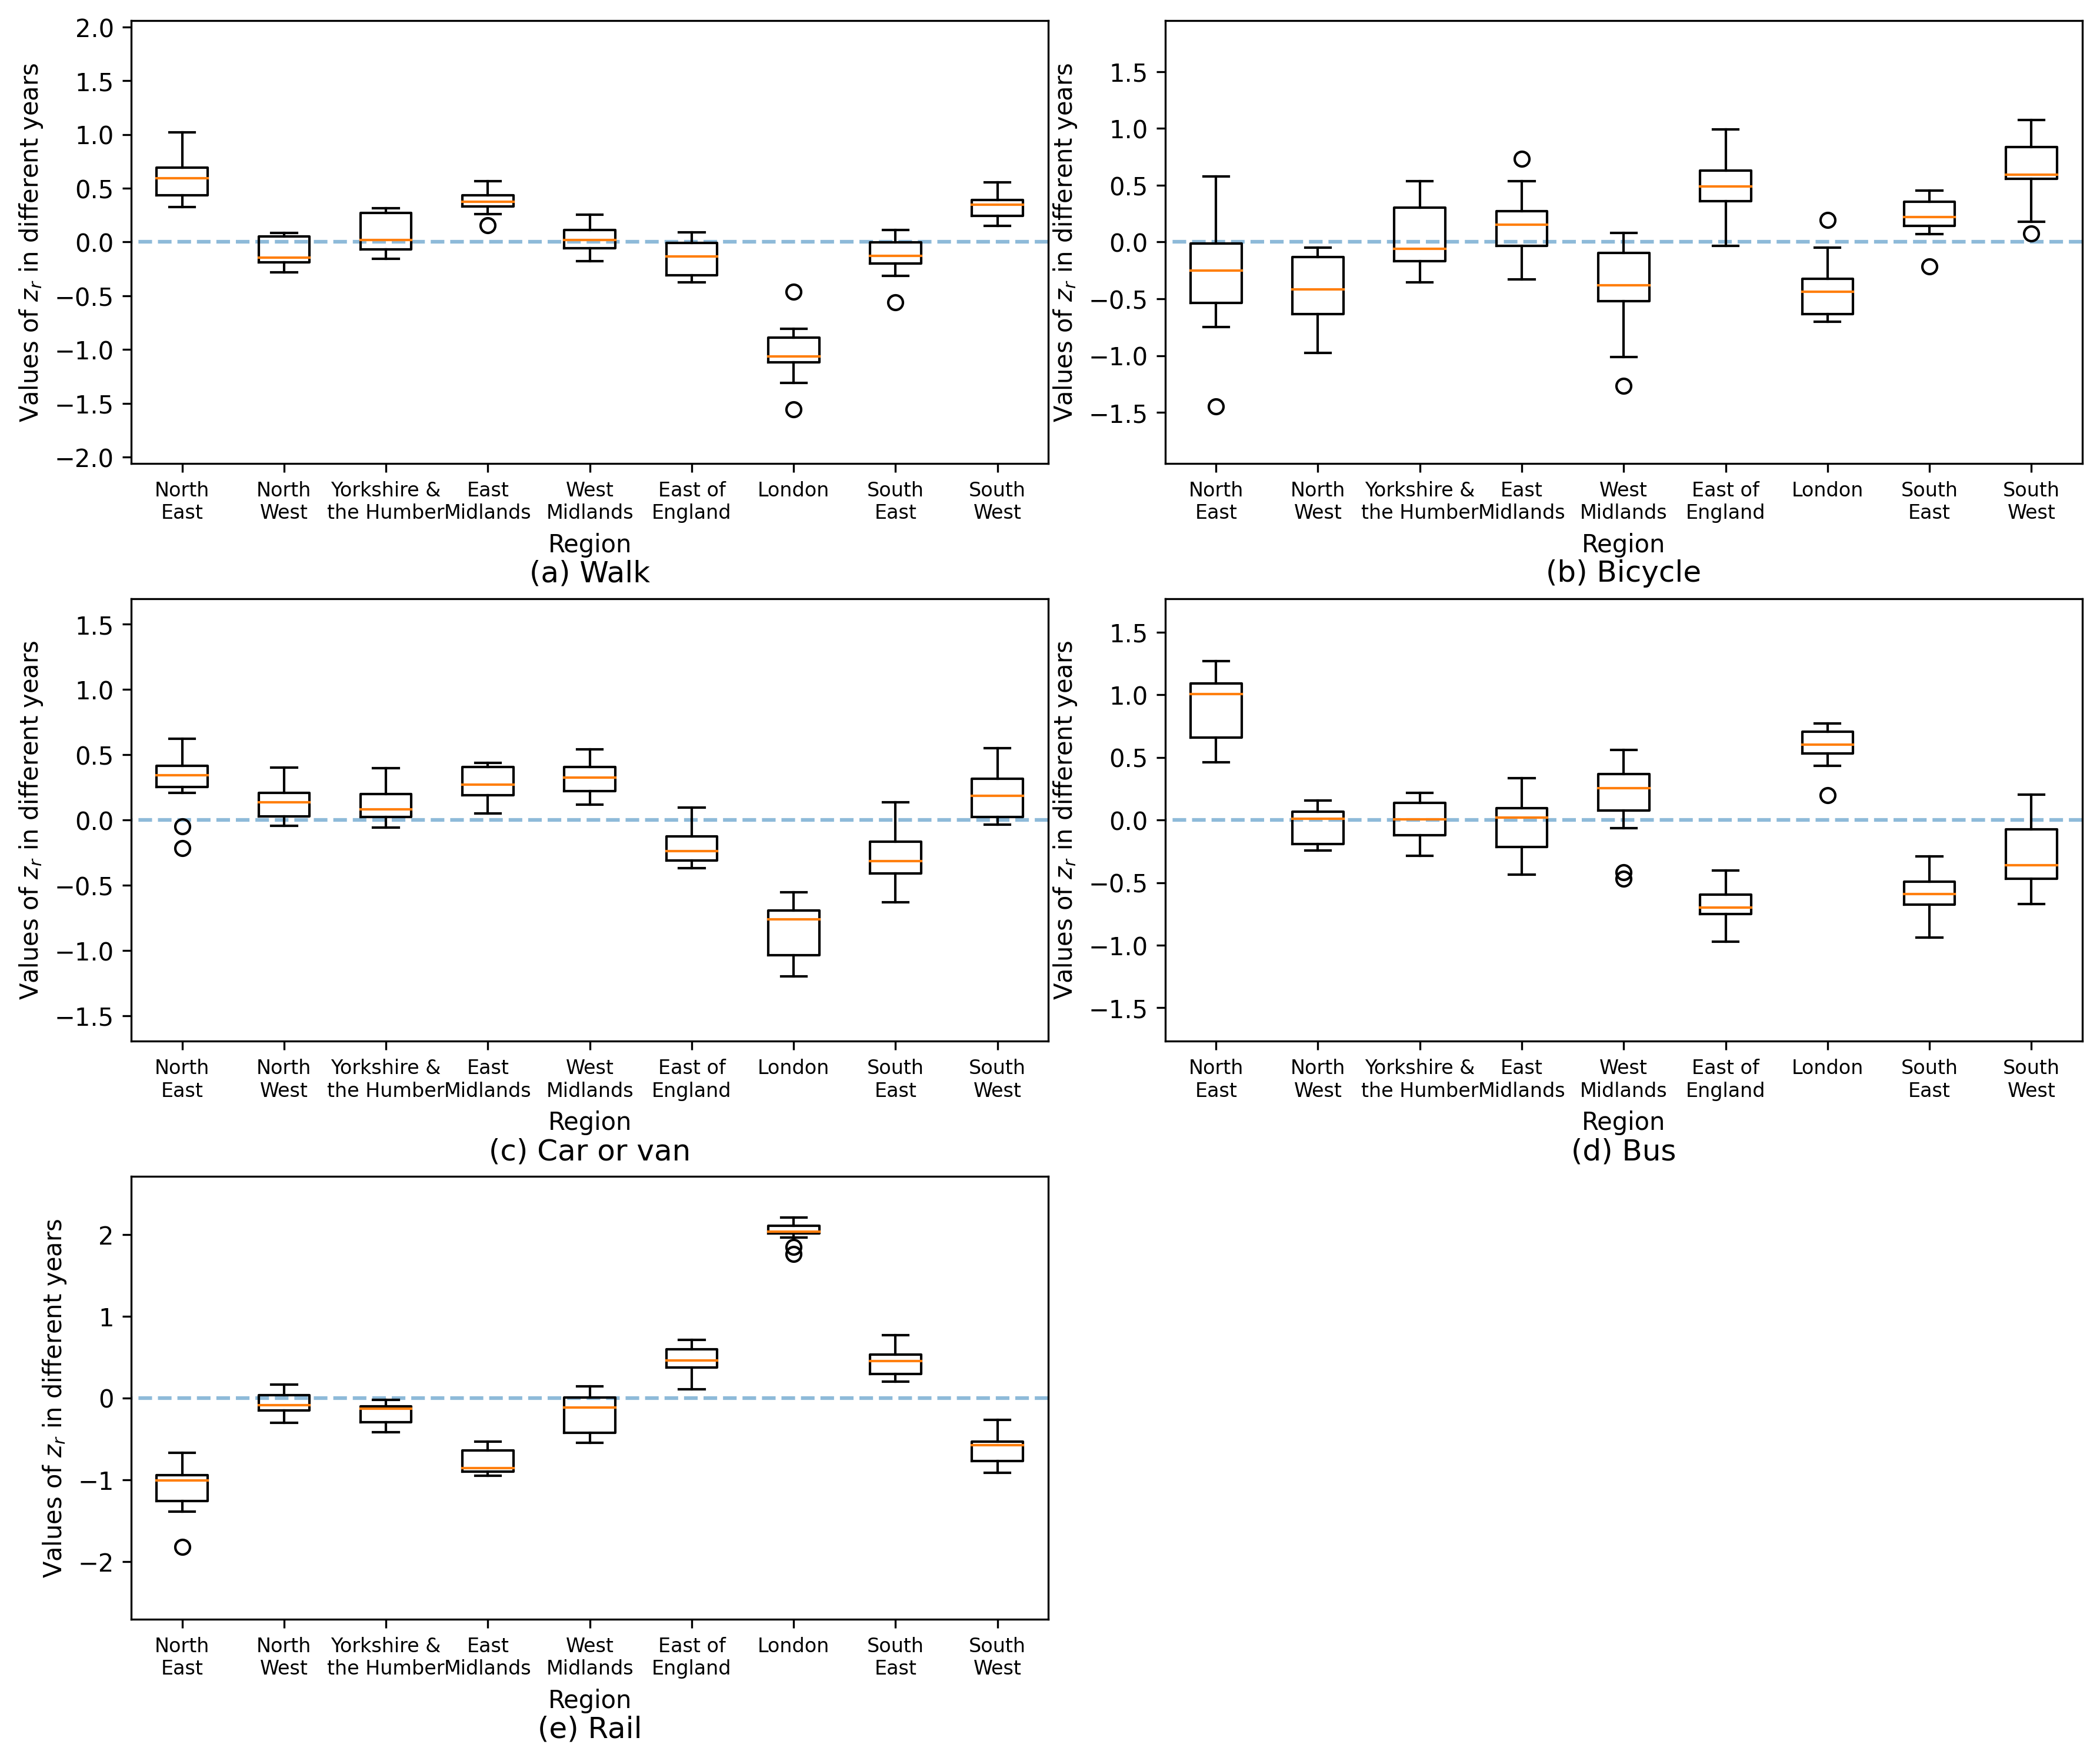

In [58]:
plot.Mode_in_Region_Plot_Stand_ave(qb_r_standard_50)
plt.savefig(f'image/Zr_variation by years.png', dpi=300)

## Probability function

This section we plot the choice probability functions with `Trip_time`.

In [62]:
#Parameter

#the variable that we want to be the x-axis
var_name='Trip_time'
var=fixed_effect.index(var_name)

#set the xsticks
xticks1_max=data[fixed_effect[var]].max()/8
xticks2_max=data_non_stand[fixed_effect[var]].max()/8
xticks_num=[0,xticks1_max/5,xticks1_max*2/5,xticks1_max*3/5,xticks1_max*4/5,xticks1_max]
xticks=[0,xticks2_max/5,xticks2_max*2/5,xticks2_max*3/5,xticks2_max*4/5,xticks2_max]

#set the ymax and ymin
ymax=1
ymin=0

# x
x=np.arange(0,xticks1_max,0.1)

#if we use scipy.signal.savgol_filter() to smooth the curves
window_length=5
polyorder=1

#the variables in RE-BNN model
vars_rebnn=nn.get_vars()
vars_rebnn.remove('Population_density')

year=years_str.index('2016')
# hold all other variables constant as their mean values
vars_mean_rebnn=list(data_list[year][vars_rebnn].mean())
vars_mean=list(data_list[year][fixed_effect].mean())

y_ave=np.zeros((len(years_str),len(travel_mode),len(x)))

#color for regions and modes
color_mode= ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd']
color_region= plt.get_cmap('jet')(np.linspace(0.1, 0.9, len(region_name)))

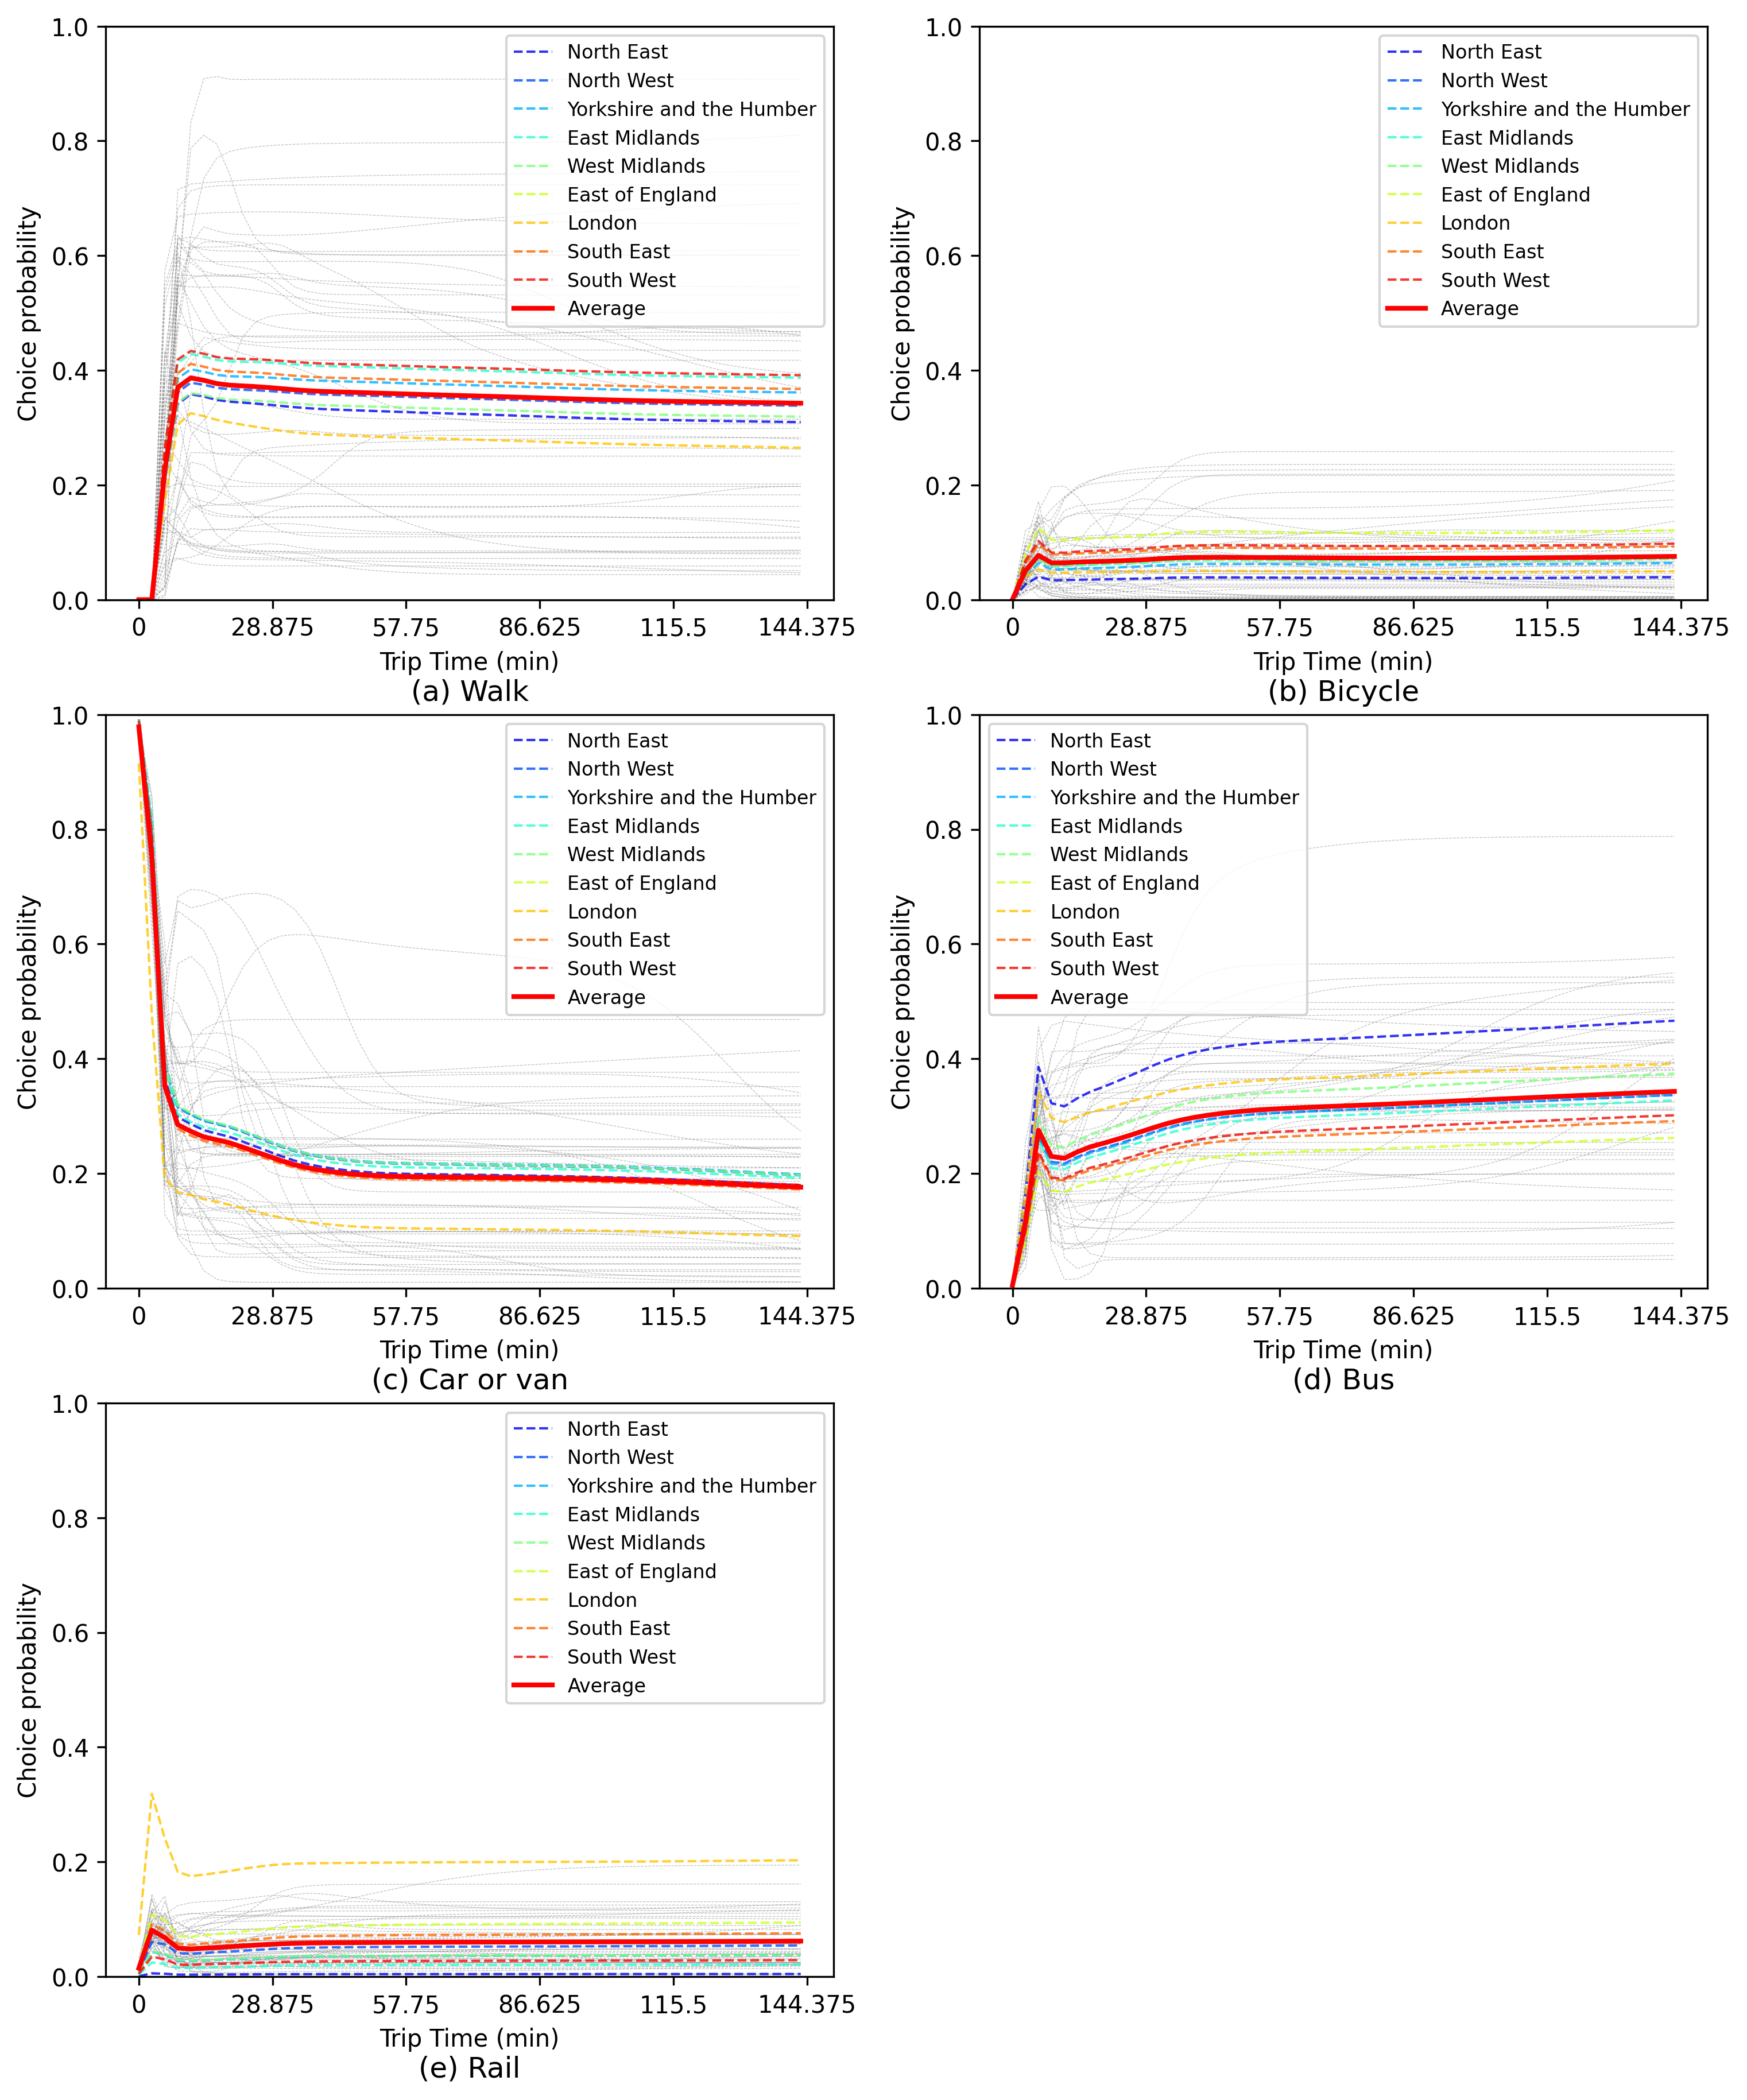

In [82]:
#the year we want to plot
year=years_str.index('2016')

# set the color and label and the linestyles
seq=['a','b','c','d','e']
ave_color='red'
linestyle='--'

#plot
fig=plt.figure(dpi=300,figsize=(12,15)) 

y_region=np.zeros((50,len(region_name),len(x)))
y_ave=np.zeros((50,len(x)))

for mode in range(len(travel_mode)):
    fig.add_subplot(3,2,mode+1)
    plt.ylim(ymax=ymax,ymin=ymin)
    #plot regional average of each training result
    for _ in range(50):
        for j in range(len(region_name)):
            y=analysis.prob_function_rebnn(x,years_str[year],result_para_rebnn_50[_],var,mode,region=j,vars_mean=vars_mean_rebnn)
#             plt.plot(x,y,linestyle=linestyle,linewidth=0.5,alpha=0.1,c='grey')
            y_region[_][j]=y
        y_ave[_]=np.mean(y_region[_],axis=0)
        plt.plot(x,y_ave[_],linestyle=linestyle,linewidth=0.3,alpha=0.5,c='grey')
        
    #plot rverage curves of training results in different regions
    for j in range(len(region_name)): 
        y=np.mean(y_region,axis=0)[j]
        plt.plot(x,y,linestyle=linestyle,linewidth=1,alpha=0.8,label=region_name[j],c=color_region[j])
    y=np.mean(y_ave,axis=0)
    plt.plot(x,y,linewidth=2,label='Average',c='red')
    plt.xlabel('Trip Time (min)')
    plt.ylabel('Choice probability')
    plt.xticks(xticks_num,xticks)
    plt.title(f'({seq[mode]}) {travel_mode[mode]}',y=-0.2)
    plt.legend(loc = 0, prop = {'size':8})

plt.savefig(f'image/Probability functions of RE-BNN learned by {years_str[year]} training set in different regions.png', dpi=300)

## Travel Mode Share

Now we choose the training results trained by 2016 dataset to test the travel mode share in different region.

In [24]:
# read the dataset(use to extract the region information of each observation)
data2016=analysis.dataset_year(2016)

In [45]:
year='2016'
#the ture market shares in 2016 testing set
mks_true=analysis.mks_region(data2016, prob_rebnn_true_50[0][year],df=True)
mks_true.to_csv(f'results\\mks_true in {year}.csv')
mks_true

Mode  North East  North West  Yorkshire and the Humber  \
0        Walk    0.100729    0.100882                  0.106456   
1     Bicycle    0.016567    0.014703                  0.018001   
2  Car or van    0.799867    0.808867                  0.813160   
3         Bus    0.082174    0.056322                  0.048417   
4        Rail    0.000663    0.019226                  0.013966   

   East Midlands  West Midlands  East of England    London  South East  \
0       0.108461       0.079895         0.090780  0.123006    0.089585   
1       0.017641       0.013462         0.029710  0.023441    0.016410   
2       0.812480       0.846649         0.807121  0.520783    0.830543   
3       0.048677       0.047703         0.027588  0.137023    0.025117   
4       0.012741       0.012291         0.044801  0.195747    0.038346   

   South West  
0    0.123526  
1    0.026390  
2    0.802920  
3    0.036777  
4    0.010387

In [51]:
mks_rebnn=np.zeros((50,len(travel_mode),len(region_name)))
mks_bnn=np.zeros((50,len(travel_mode),len(region_name)))
mks_dnn=np.zeros((50,len(travel_mode),len(region_name)))
for _ in range(50):
    mks_rebnn[_]=analysis.mks_region(data2016, prob_rebnn_pre_50[_][year])
    mks_bnn[_]=analysis.mks_region(data2016, prob_bnn_pre_50[_][year])
    mks_dnn[_]=analysis.mks_region(data2016, prob_dnn_pre_50[_][year])
mks_mnl=analysis.mks_region(data2016, prob_mnl_pre[year])

In [54]:
pd.DataFrame(np.mean(mks_rebnn,axis=0)).to_csv(f'results\\mks_rebnn(ave) in {year}.csv')
pd.DataFrame(np.mean(mks_bnn,axis=0)).to_csv(f'results\\mks_bnn(ave) in {year}.csv')
pd.DataFrame(np.mean(mks_dnn,axis=0)).to_csv(f'results\\mks_dnn(ave) in {year}.csv')

pd.DataFrame(np.std(mks_rebnn,axis=0)).to_csv(f'results\\mks_rebnn(std) in {year}.csv')
pd.DataFrame(np.std(mks_bnn,axis=0)).to_csv(f'results\\mks_bnn(std) in {year}.csv')
pd.DataFrame(np.std(mks_dnn,axis=0)).to_csv(f'results\\mks_dnn(std) in {year}.csv')

pd.DataFrame(mks_mnl).to_csv(f'results\\mks_mnl in {year}.csv')